In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

2025-05-28 13:36:22.078389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748439382.287435      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748439382.349463      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def train_phase(phase_path, sample=False, epochs=50, batch_size=32):
    best_model = None
    best_score = 0
    all_metrics = []

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")

        if sample:
            scaler = joblib.load(f"{fold_path}/scaler.pkl")
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            scaler = RobustScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        num_classes = len(np.unique(y_train))
        y_train_cat = to_categorical(y_train, num_classes=num_classes)
        y_val_cat = to_categorical(y_val, num_classes=num_classes)

        X_train_reshaped = np.expand_dims(X_train.values, axis=2)
        X_val_reshaped = np.expand_dims(X_val.values, axis=2)

        model = build_cnn_model(input_shape=X_train_reshaped.shape[1:], num_classes=num_classes)

        early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        model.fit(X_train_reshaped, y_train_cat, validation_data=(X_val_reshaped, y_val_cat),
                  epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])

        y_pred_probs = model.predict(X_val_reshaped)
        y_pred = np.argmax(y_pred_probs, axis=1)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(to_categorical(y_val), y_pred_probs, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(to_categorical(y_val)[:, i], y_pred_probs[:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics



======= Training Phase 1 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748439394.734768      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748439394.735466      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1748439399.289127      63 service.cc:148] XLA service 0x7b2f9c0062e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748439399.290088      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748439399.290105      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748439399.663742      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


 59/340 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5885 - loss: 1.5308

I0000 00:00:1748439403.056210      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6255 - loss: 1.2302 - val_accuracy: 0.6670 - val_loss: 0.9171
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6608 - loss: 0.9038 - val_accuracy: 0.6825 - val_loss: 0.8265
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6769 - loss: 0.8532 - val_accuracy: 0.6810 - val_loss: 0.8080
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6763 - loss: 0.8528 - val_accuracy: 0.6858 - val_loss: 0.7948
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6762 - loss: 0.8241 - val_accuracy: 0.6877 - val_loss: 0.7734
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6814 - loss: 0.8057 - val_accuracy: 0.6858 - val_loss: 0.7642
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6752 - loss: 0.8021 - val_accuracy: 0.6994 - val_loss: 0.7560
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6785 - loss: 0.8018 - val_accuracy: 0.6965 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


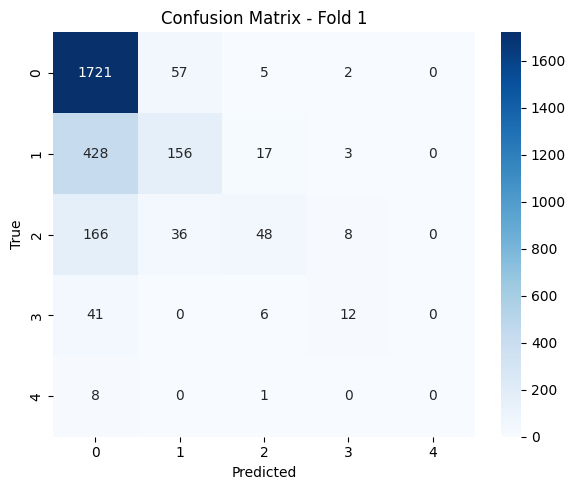

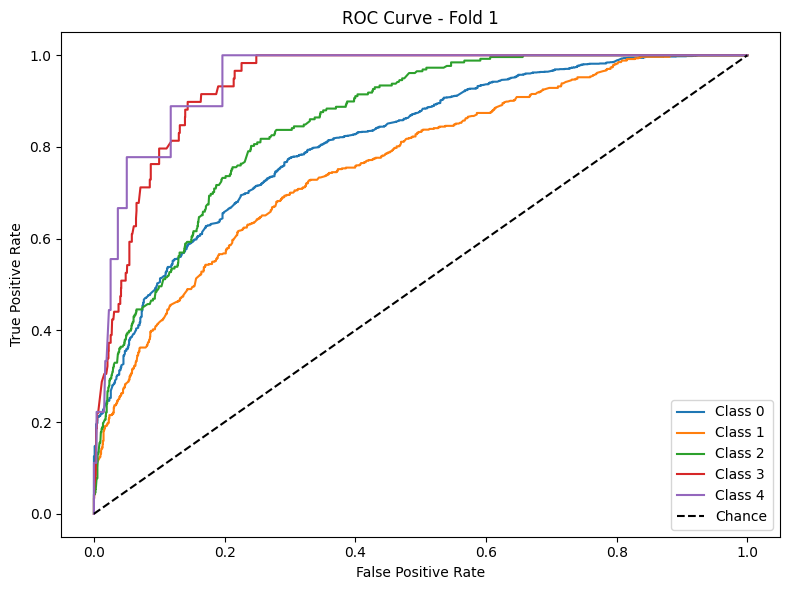

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6159 - loss: 1.2412 - val_accuracy: 0.6647 - val_loss: 0.8992
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6616 - loss: 0.8914 - val_accuracy: 0.6761 - val_loss: 0.8397
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6693 - loss: 0.8580 - val_accuracy: 0.6772 - val_loss: 0.8261
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6643 - loss: 0.8392 - val_accuracy: 0.6765 - val_loss: 0.8069
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6709 - loss: 0.8297 - val_accuracy: 0.6809 - val_loss: 0.8053
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6764 - loss: 0.8152 - val_accuracy: 0.6875 - val_loss: 0.8128
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6793 - loss: 0.8138 - val_accuracy: 0.6861 - val_loss: 0.7832
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6903 - loss: 0.7948 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


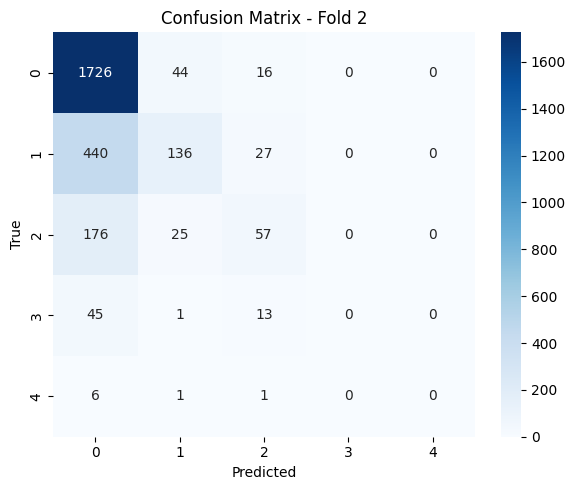

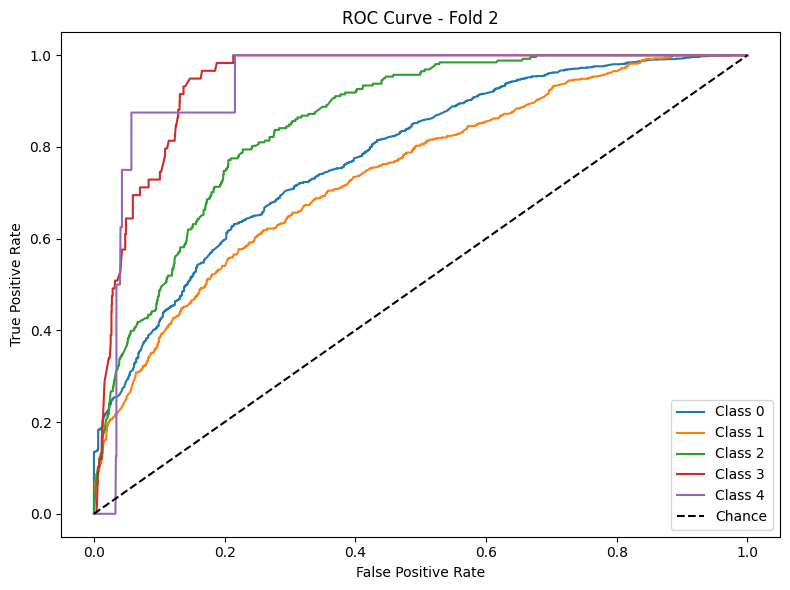

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5990 - loss: 1.2570 - val_accuracy: 0.6647 - val_loss: 0.9181
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.8892 - val_accuracy: 0.6658 - val_loss: 0.8217
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6601 - loss: 0.8717 - val_accuracy: 0.6820 - val_loss: 0.8217
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6779 - loss: 0.8453 - val_accuracy: 0.6809 - val_loss: 0.7962
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6734 - loss: 0.8191 - val_accuracy: 0.6894 - val_loss: 0.7608
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6732 - loss: 0.8206 - val_accuracy: 0.6853 - val_loss: 0.7559
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6813 - loss: 0.8064 - val_accuracy: 0.6934 - val_loss: 0.7488
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6772 - loss: 0.8083 - val_accuracy: 0.6949 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


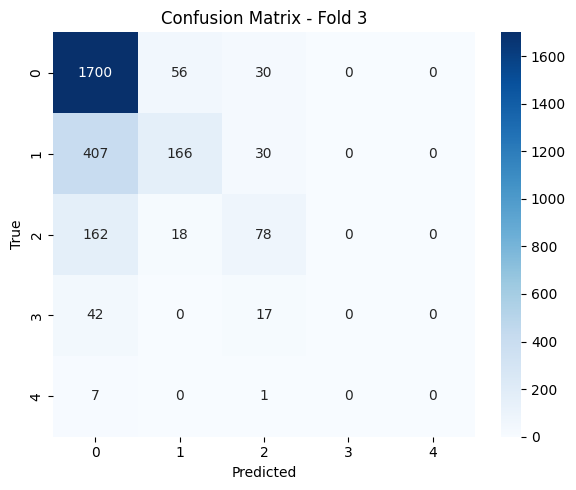

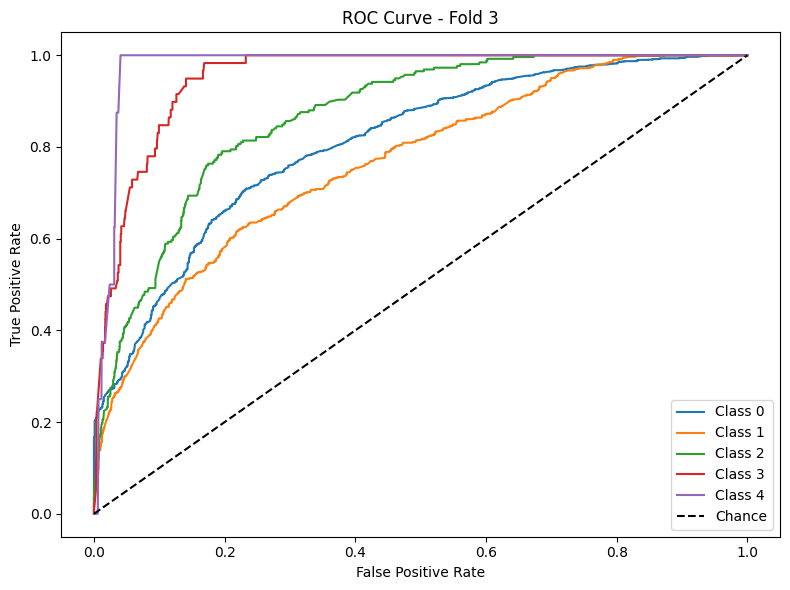

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6132 - loss: 1.2539 - val_accuracy: 0.6728 - val_loss: 0.8879
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6505 - loss: 0.9082 - val_accuracy: 0.6625 - val_loss: 0.8080
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6572 - loss: 0.8667 - val_accuracy: 0.6864 - val_loss: 0.7911
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6628 - loss: 0.8348 - val_accuracy: 0.6817 - val_loss: 0.7734
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6809 - loss: 0.8059 - val_accuracy: 0.7027 - val_loss: 0.7607
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6763 - loss: 0.8168 - val_accuracy: 0.7049 - val_loss: 0.7570
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6708 - loss: 0.8165 - val_accuracy: 0.7027 - val_loss: 0.7405
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6817 - loss: 0.7932 - val_accuracy: 0.7119 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


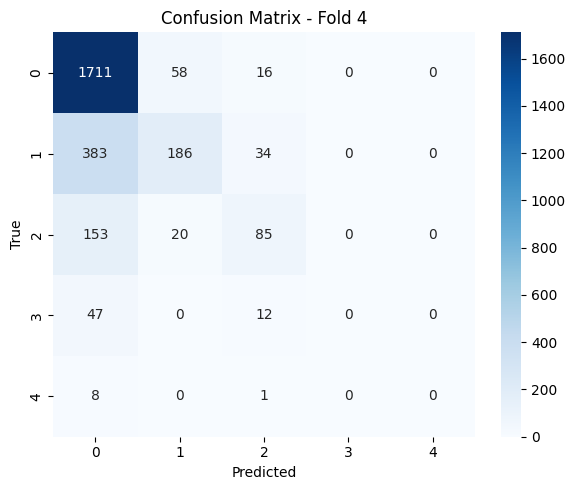

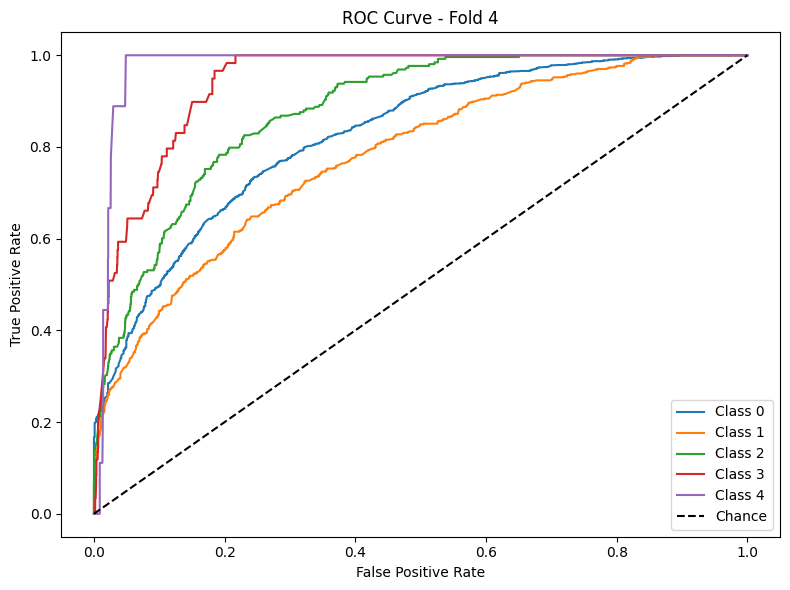

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6096 - loss: 1.2663 - val_accuracy: 0.6739 - val_loss: 0.9034
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6593 - loss: 0.9173 - val_accuracy: 0.6787 - val_loss: 0.8225
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6743 - loss: 0.8516 - val_accuracy: 0.6817 - val_loss: 0.7990
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6707 - loss: 0.8409 - val_accuracy: 0.6857 - val_loss: 0.7815
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6684 - loss: 0.8315 - val_accuracy: 0.6861 - val_loss: 0.7785
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6703 - loss: 0.8318 - val_accuracy: 0.6898 - val_loss: 0.7644
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6843 - loss: 0.8030 - val_accuracy: 0.6990 - val_loss: 0.7594
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6779 - loss: 0.8048 - val_accuracy: 0.6938 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


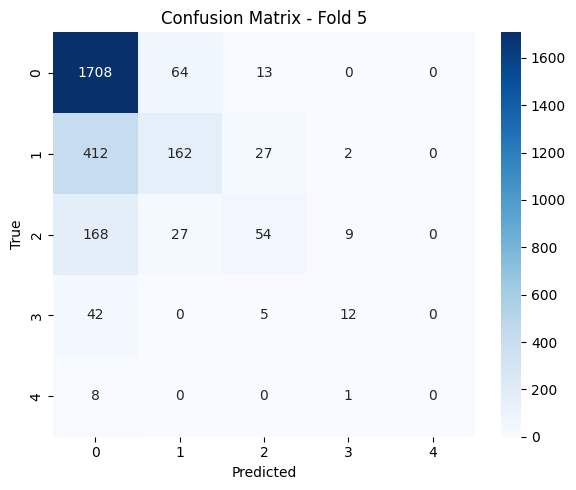

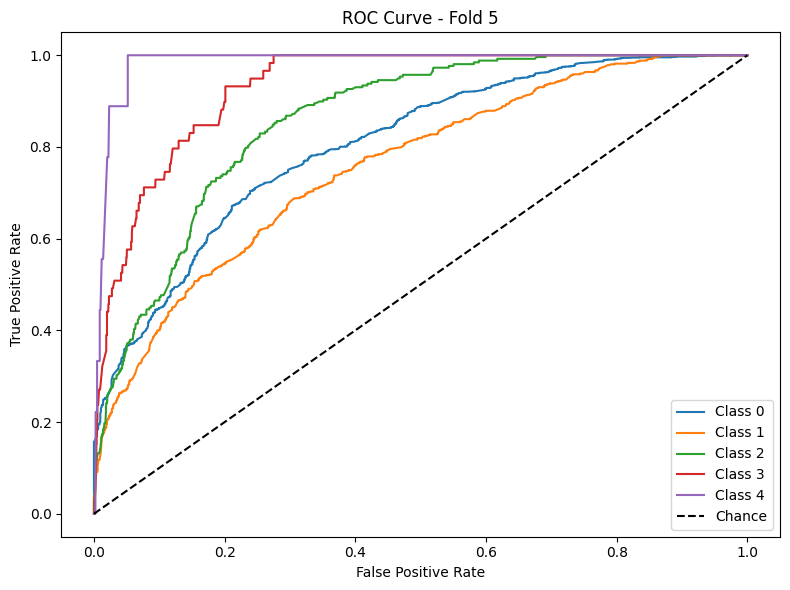


Average Accuracy: 0.7161
Average F1 Macro: 0.3328
Average AUC: 0.8678


======= Training Phase 2 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5911 - loss: 1.4546 - val_accuracy: 0.6580 - val_loss: 0.9395
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6545 - loss: 0.9405 - val_accuracy: 0.6642 - val_loss: 0.8721
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6626 - loss: 0.8751 - val_accuracy: 0.6739 - val_loss: 0.8394
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6786 - loss: 0.8347 - val_accuracy: 0.6792 - val_loss: 0.8225
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6754 - loss: 0.8512 - val_accuracy: 0.6792 - val_loss: 0.8008
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6836 - loss: 0.8301 - val_accuracy: 0.6779 - val_loss: 0.8040
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6751 - loss: 0.8207 - val_accuracy: 0.6827 - val_loss: 0.7868
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6781 - loss: 0.8079 - val_accuracy: 0.6845 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


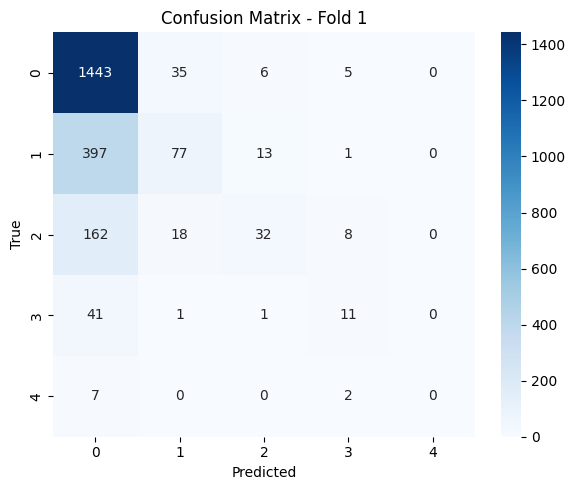

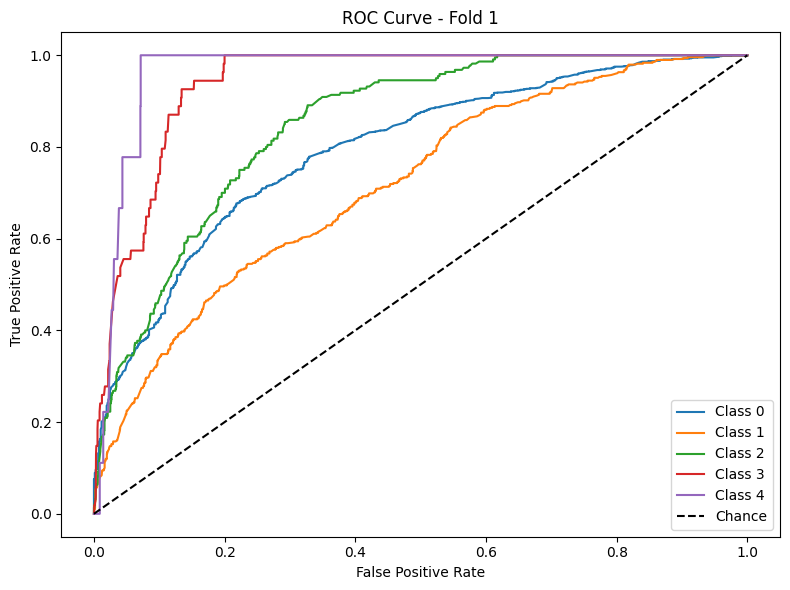

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6243 - loss: 1.3289 - val_accuracy: 0.6588 - val_loss: 0.9589
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6535 - loss: 0.9346 - val_accuracy: 0.6558 - val_loss: 0.8814
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6616 - loss: 0.8980 - val_accuracy: 0.6743 - val_loss: 0.8205
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6659 - loss: 0.8586 - val_accuracy: 0.6743 - val_loss: 0.7923
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6681 - loss: 0.8530 - val_accuracy: 0.6774 - val_loss: 0.7953
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6745 - loss: 0.8303 - val_accuracy: 0.6752 - val_loss: 0.7945
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6728 - loss: 0.8342 - val_accuracy: 0.6823 - val_loss: 0.7860
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6690 - loss: 0.8280 - val_accuracy: 0.6827 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


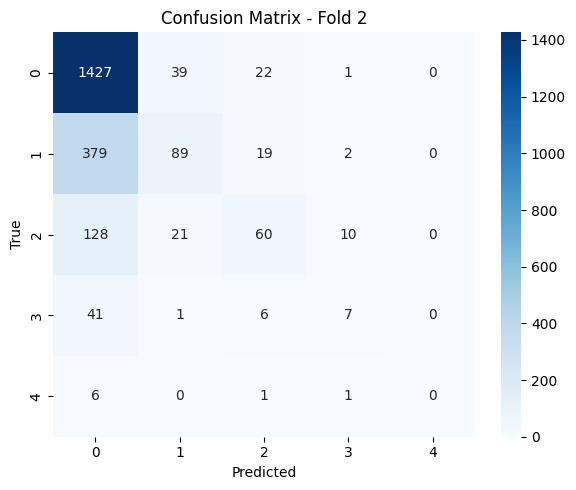

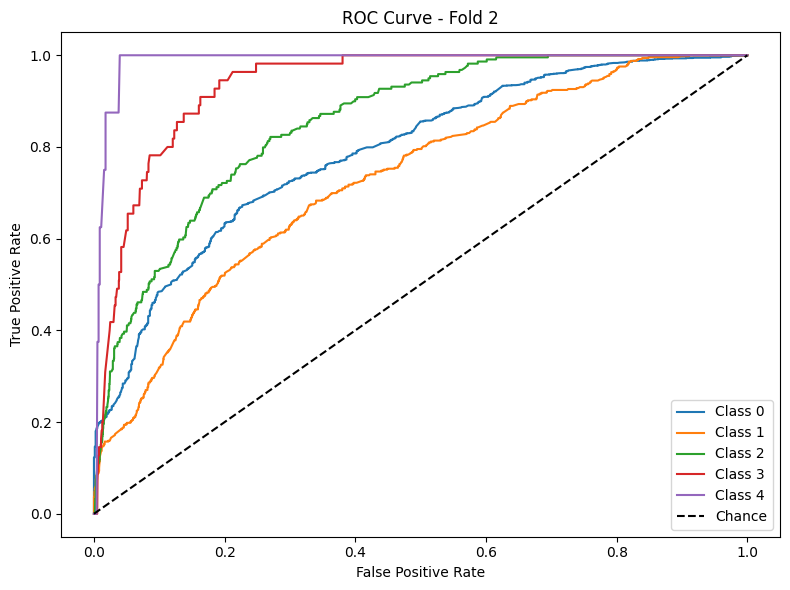

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6018 - loss: 1.4190 - val_accuracy: 0.6587 - val_loss: 0.9200
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6564 - loss: 0.9210 - val_accuracy: 0.6591 - val_loss: 0.8537
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6623 - loss: 0.8759 - val_accuracy: 0.6676 - val_loss: 0.8822
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6762 - loss: 0.8497 - val_accuracy: 0.6751 - val_loss: 0.8121
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6671 - loss: 0.8462 - val_accuracy: 0.6773 - val_loss: 0.8004
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6687 - loss: 0.8410 - val_accuracy: 0.6768 - val_loss: 0.7910
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6774 - loss: 0.8221 - val_accuracy: 0.6786 - val_loss: 0.7935
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6696 - loss: 0.8312 - val_accuracy: 0.6782 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


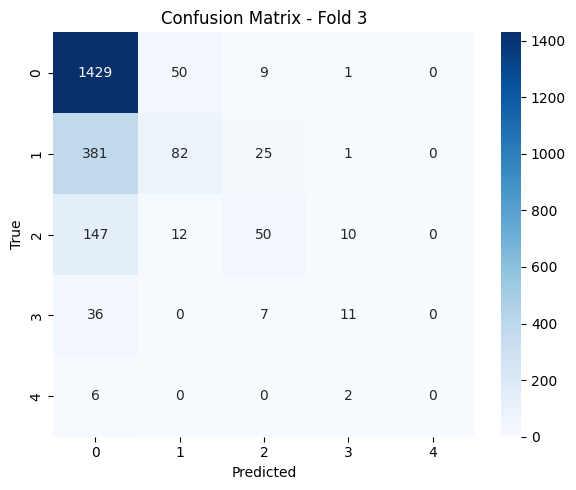

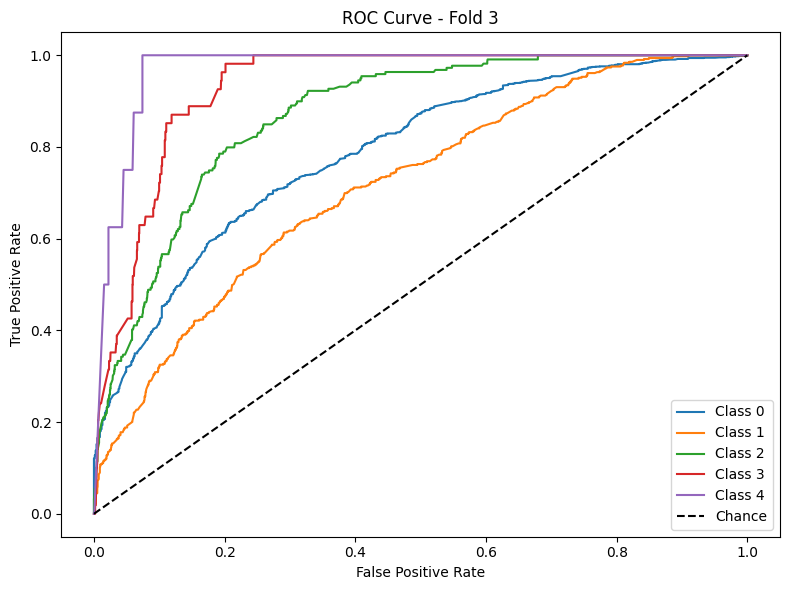

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5995 - loss: 1.4435 - val_accuracy: 0.6605 - val_loss: 0.9463
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6548 - loss: 0.9459 - val_accuracy: 0.6600 - val_loss: 0.8550
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6520 - loss: 0.9033 - val_accuracy: 0.6755 - val_loss: 0.8408
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.8761 - val_accuracy: 0.6746 - val_loss: 0.8118
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6727 - loss: 0.8516 - val_accuracy: 0.6760 - val_loss: 0.8026
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6631 - loss: 0.8447 - val_accuracy: 0.6822 - val_loss: 0.7862
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6679 - loss: 0.8326 - val_accuracy: 0.6830 - val_loss: 0.7821
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6736 - loss: 0.8179 - val_accuracy: 0.6853 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


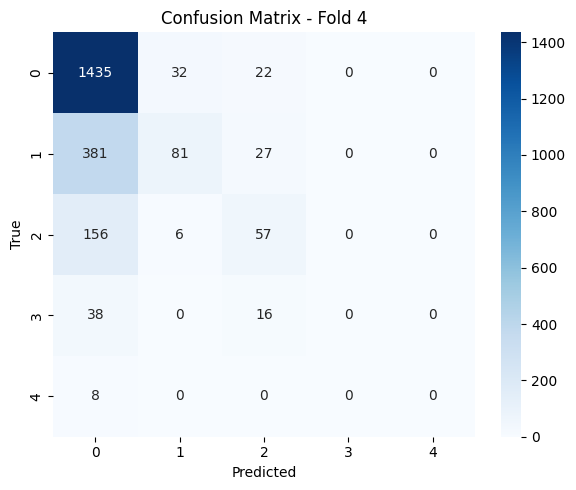

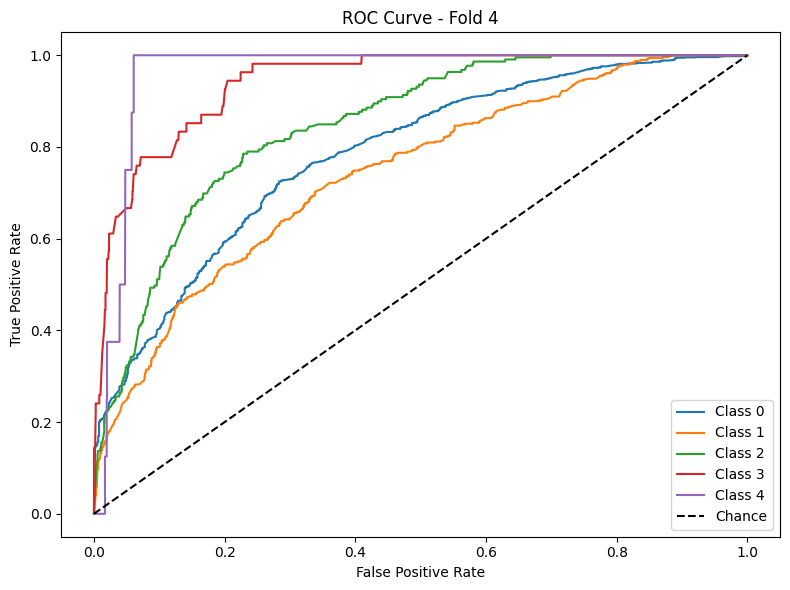

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6117 - loss: 1.3867 - val_accuracy: 0.6569 - val_loss: 0.9734
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6504 - loss: 0.9535 - val_accuracy: 0.6614 - val_loss: 0.8523
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6582 - loss: 0.9091 - val_accuracy: 0.6724 - val_loss: 0.8159
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6657 - loss: 0.8596 - val_accuracy: 0.6729 - val_loss: 0.8143
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6607 - loss: 0.8623 - val_accuracy: 0.6822 - val_loss: 0.7936
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6752 - loss: 0.8207 - val_accuracy: 0.6839 - val_loss: 0.7801
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6757 - loss: 0.8283 - val_accuracy: 0.6835 - val_loss: 0.7669
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6730 - loss: 0.8198 - val_accuracy: 0.6884 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


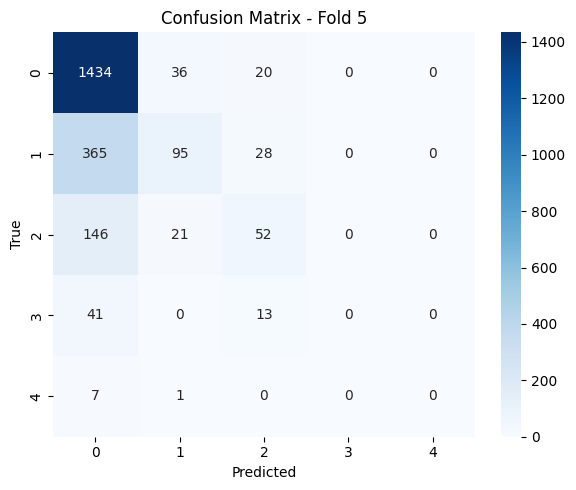

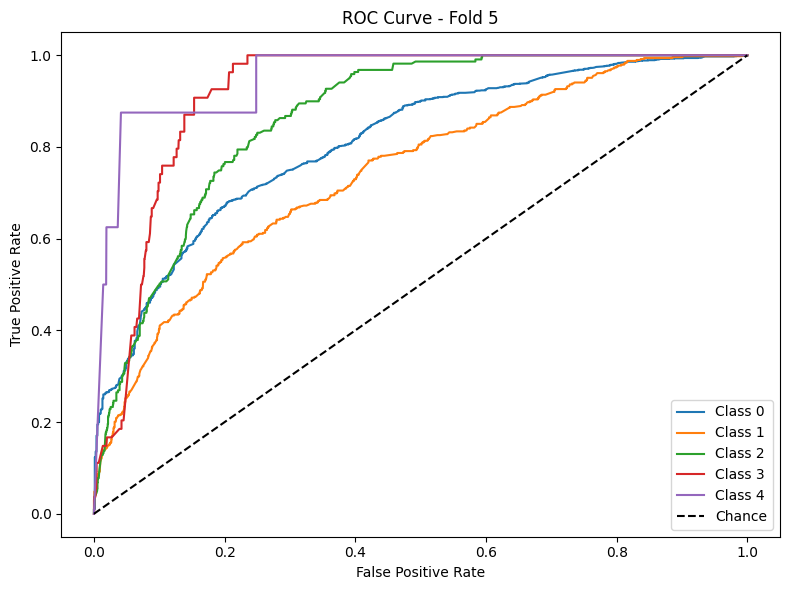


Average Accuracy: 0.6968
Average F1 Macro: 0.3102
Average AUC: 0.8561


======= Training Phase 3 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5967 - loss: 1.4654 - val_accuracy: 0.6553 - val_loss: 0.9457
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6526 - loss: 0.9396 - val_accuracy: 0.6562 - val_loss: 0.8637
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6684 - loss: 0.8823 - val_accuracy: 0.6543 - val_loss: 0.8388
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6621 - loss: 0.9009 - val_accuracy: 0.6760 - val_loss: 0.8215
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6665 - loss: 0.8549 - val_accuracy: 0.6755 - val_loss: 0.8073
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6722 - loss: 0.8531 - val_accuracy: 0.6770 - val_loss: 0.7768
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6817 - loss: 0.8059 - val_accuracy: 0.6808 - val_loss: 0.7747
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6689 - loss: 0.8232 - val_accuracy: 0.6832 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


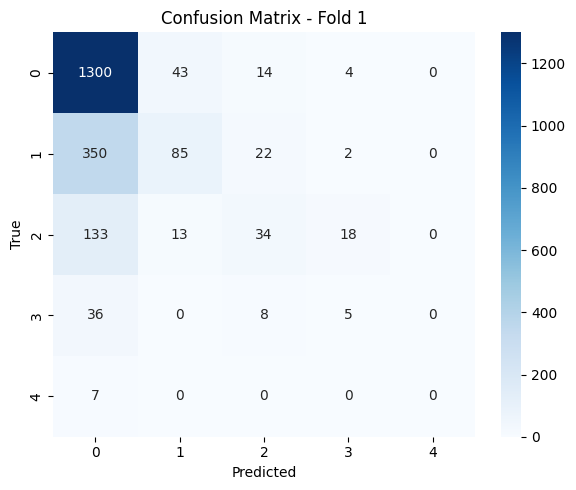

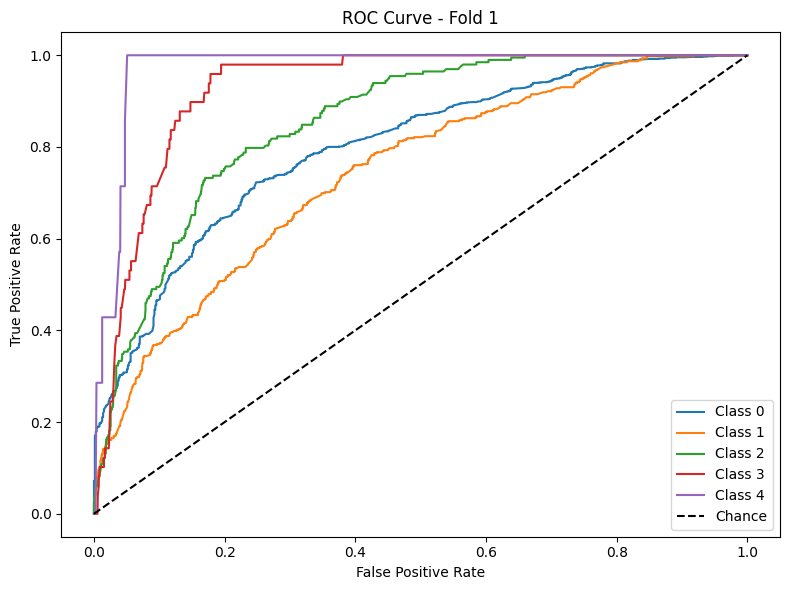

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6077 - loss: 1.4827 - val_accuracy: 0.6504 - val_loss: 0.9370
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6469 - loss: 0.9468 - val_accuracy: 0.6548 - val_loss: 0.8675
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6559 - loss: 0.8853 - val_accuracy: 0.6702 - val_loss: 0.8131
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6633 - loss: 0.8734 - val_accuracy: 0.6726 - val_loss: 0.8207
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6691 - loss: 0.8486 - val_accuracy: 0.6712 - val_loss: 0.8009
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6598 - loss: 0.8647 - val_accuracy: 0.6712 - val_loss: 0.7886
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6659 - loss: 0.8297 - val_accuracy: 0.6895 - val_loss: 0.7784
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6662 - loss: 0.8338 - val_accuracy: 0.6851 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


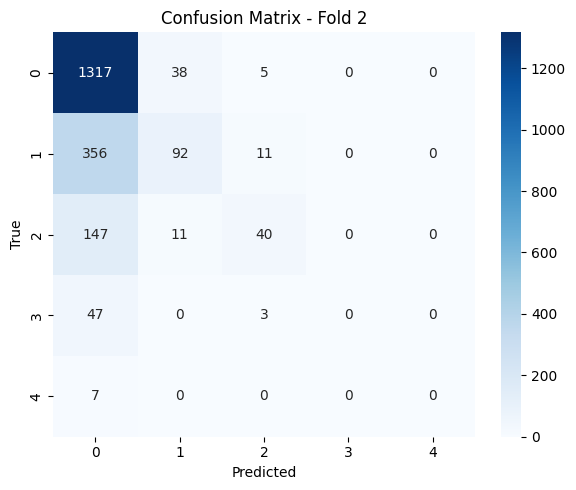

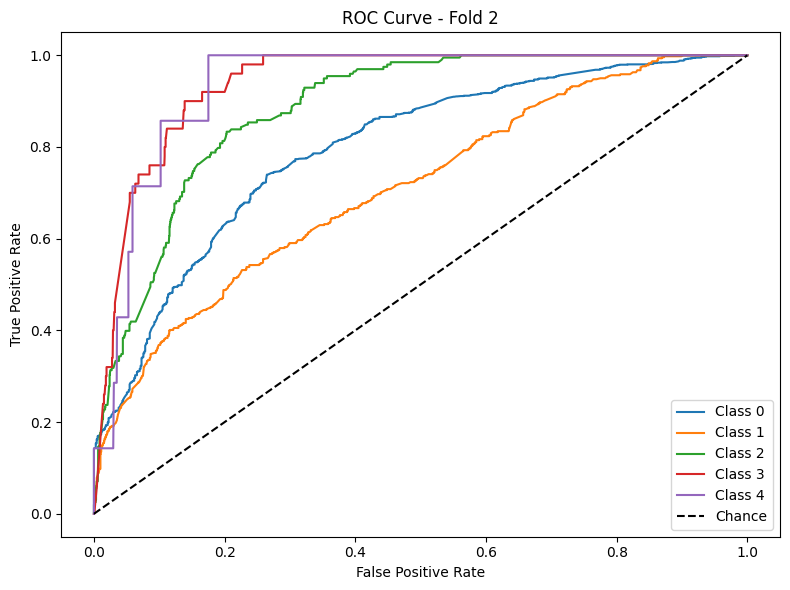

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5882 - loss: 1.5292 - val_accuracy: 0.6572 - val_loss: 0.9279
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6587 - loss: 0.9275 - val_accuracy: 0.6562 - val_loss: 0.8723
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6449 - loss: 0.9306 - val_accuracy: 0.6770 - val_loss: 0.8398
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6526 - loss: 0.8786 - val_accuracy: 0.6798 - val_loss: 0.8258
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6645 - loss: 0.8432 - val_accuracy: 0.6784 - val_loss: 0.8148
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6632 - loss: 0.8535 - val_accuracy: 0.6808 - val_loss: 0.7861
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6707 - loss: 0.8151 - val_accuracy: 0.6851 - val_loss: 0.7965
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6762 - loss: 0.8023 - val_accuracy: 0.6929 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


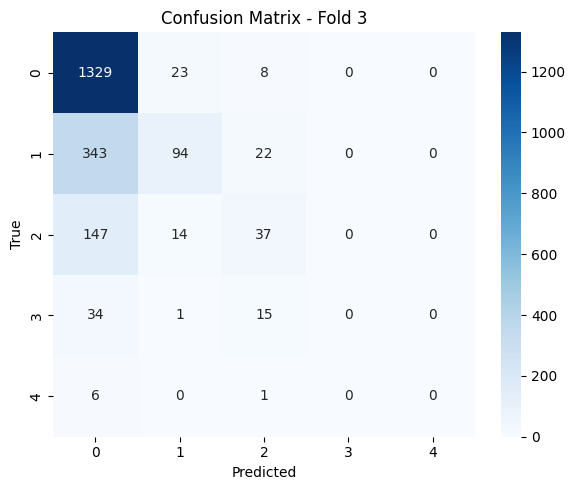

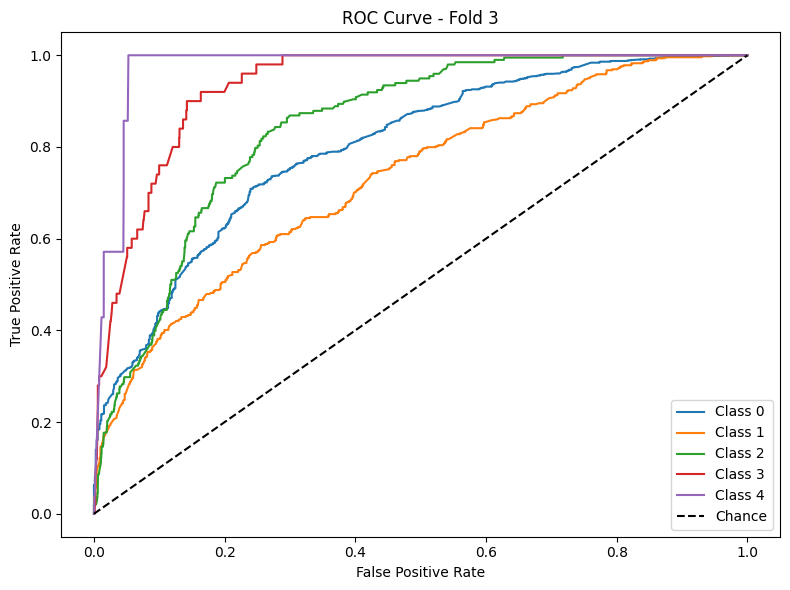

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6050 - loss: 1.4520 - val_accuracy: 0.6365 - val_loss: 1.0197
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6531 - loss: 0.9475 - val_accuracy: 0.6663 - val_loss: 0.8912
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6760 - loss: 0.8582 - val_accuracy: 0.6716 - val_loss: 0.8276
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6621 - loss: 0.8510 - val_accuracy: 0.6716 - val_loss: 0.8017
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6585 - loss: 0.8647 - val_accuracy: 0.6697 - val_loss: 0.7902
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6792 - loss: 0.8094 - val_accuracy: 0.6606 - val_loss: 0.7918
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6668 - loss: 0.8152 - val_accuracy: 0.6741 - val_loss: 0.7836
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6711 - loss: 0.8098 - val_accuracy: 0.6803 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


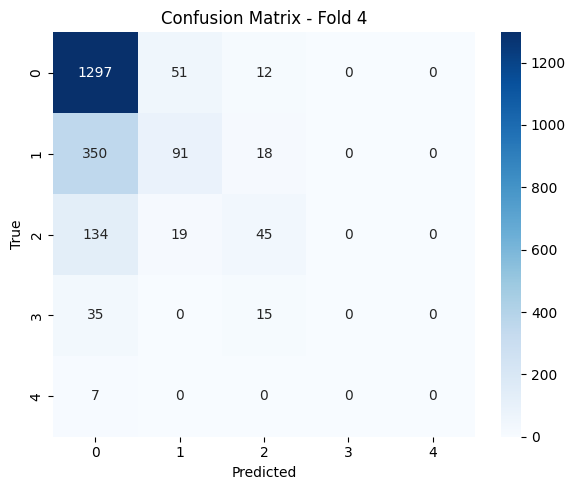

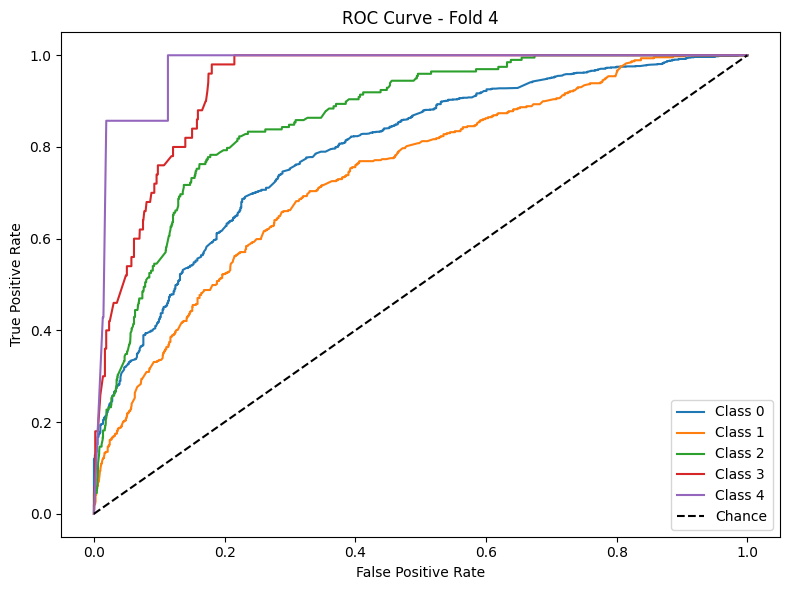

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5900 - loss: 1.5001 - val_accuracy: 0.6450 - val_loss: 1.0214
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6528 - loss: 0.9604 - val_accuracy: 0.6652 - val_loss: 0.8681
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6618 - loss: 0.8925 - val_accuracy: 0.6734 - val_loss: 0.8456
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6651 - loss: 0.8567 - val_accuracy: 0.6686 - val_loss: 0.8293
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6687 - loss: 0.8560 - val_accuracy: 0.6749 - val_loss: 0.8151
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6686 - loss: 0.8380 - val_accuracy: 0.6739 - val_loss: 0.8001
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6769 - loss: 0.8185 - val_accuracy: 0.6729 - val_loss: 0.8085
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6707 - loss: 0.8194 - val_accuracy: 0.6763 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


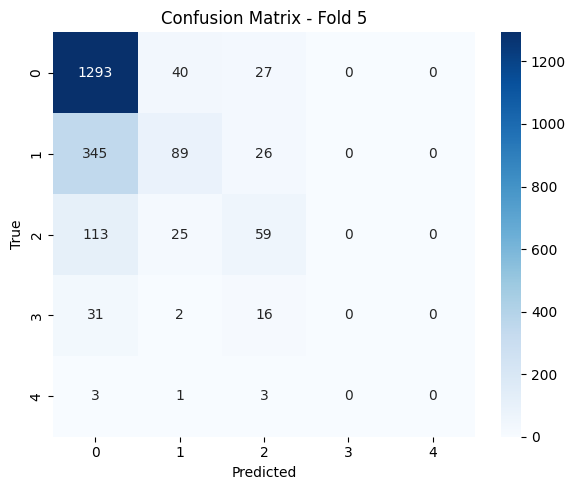

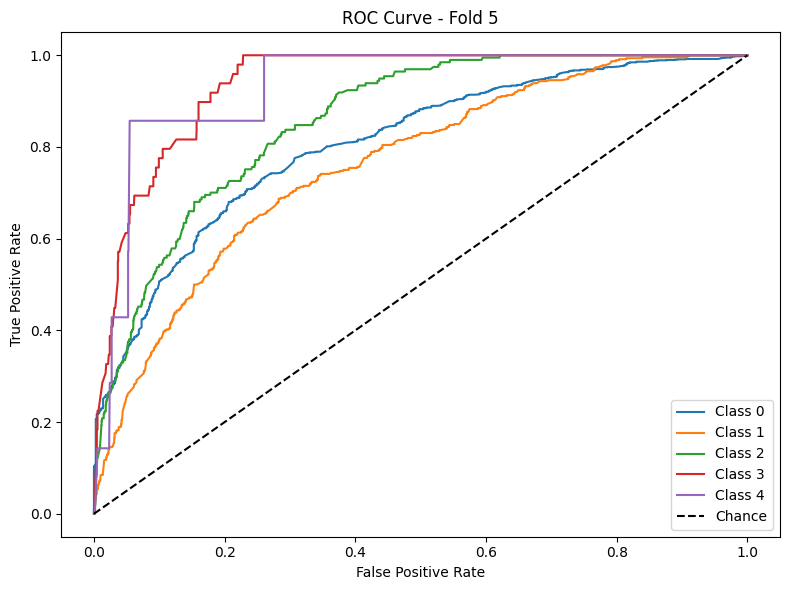


Average Accuracy: 0.6951
Average F1 Macro: 0.2882
Average AUC: 0.8580


======= Training Phase 4 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5937 - loss: 1.5837 - val_accuracy: 0.6433 - val_loss: 1.0277
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6444 - loss: 0.9442 - val_accuracy: 0.6485 - val_loss: 0.9046
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6524 - loss: 0.9184 - val_accuracy: 0.6517 - val_loss: 0.8714
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6607 - loss: 0.8666 - val_accuracy: 0.6615 - val_loss: 0.8265
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6624 - loss: 0.8450 - val_accuracy: 0.6654 - val_loss: 0.8225
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6688 - loss: 0.8310 - val_accuracy: 0.6641 - val_loss: 0.8061
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6656 - loss: 0.8112 - val_accuracy: 0.6641 - val_loss: 0.8017
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6720 - loss: 0.8056 - val_accuracy: 0.6706 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


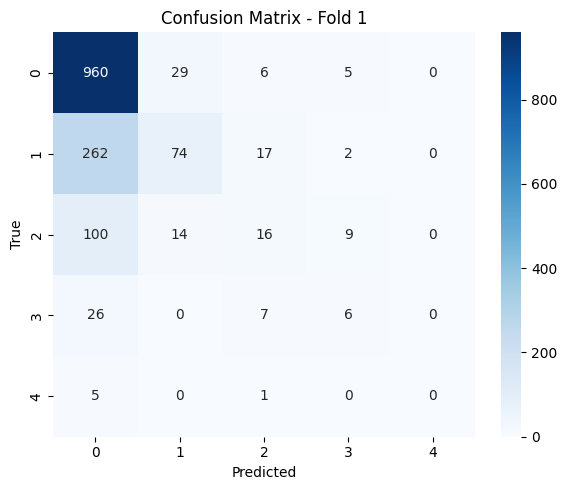

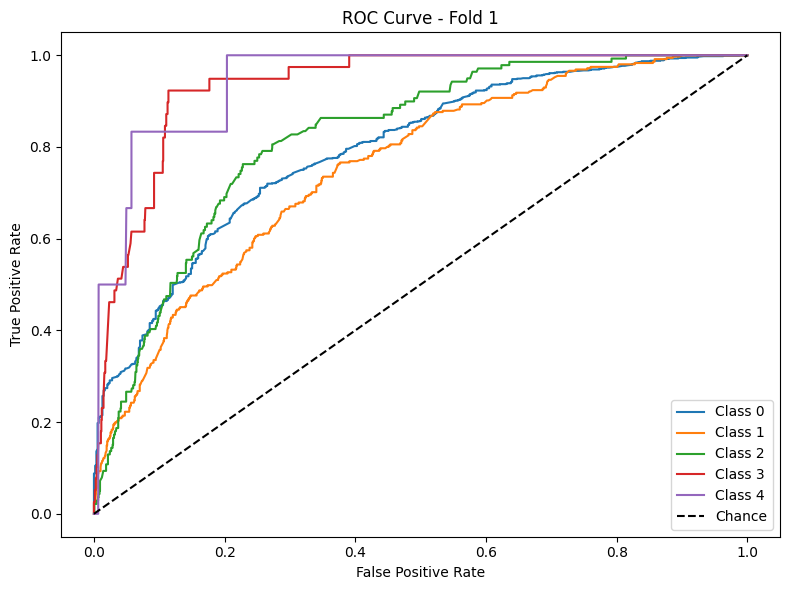

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5925 - loss: 1.5660 - val_accuracy: 0.6517 - val_loss: 1.0082
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6408 - loss: 0.9888 - val_accuracy: 0.6452 - val_loss: 0.9226
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6606 - loss: 0.8991 - val_accuracy: 0.6641 - val_loss: 0.8390
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6611 - loss: 0.8574 - val_accuracy: 0.6751 - val_loss: 0.8209
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6652 - loss: 0.8660 - val_accuracy: 0.6745 - val_loss: 0.7909
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6665 - loss: 0.8495 - val_accuracy: 0.6758 - val_loss: 0.8192
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6658 - loss: 0.8130 - val_accuracy: 0.6875 - val_loss: 0.7839
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6813 - loss: 0.8069 - val_accuracy: 0.6979 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


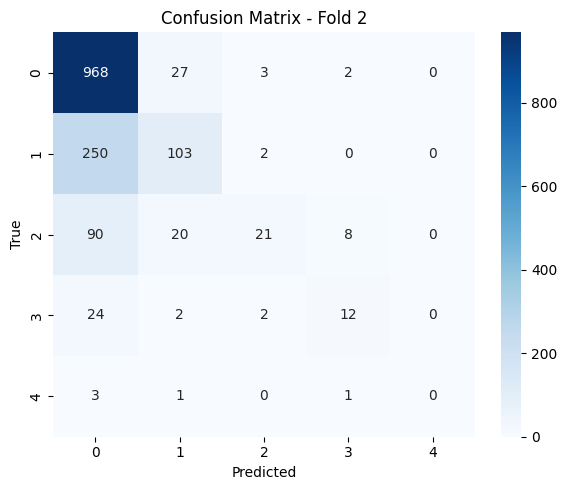

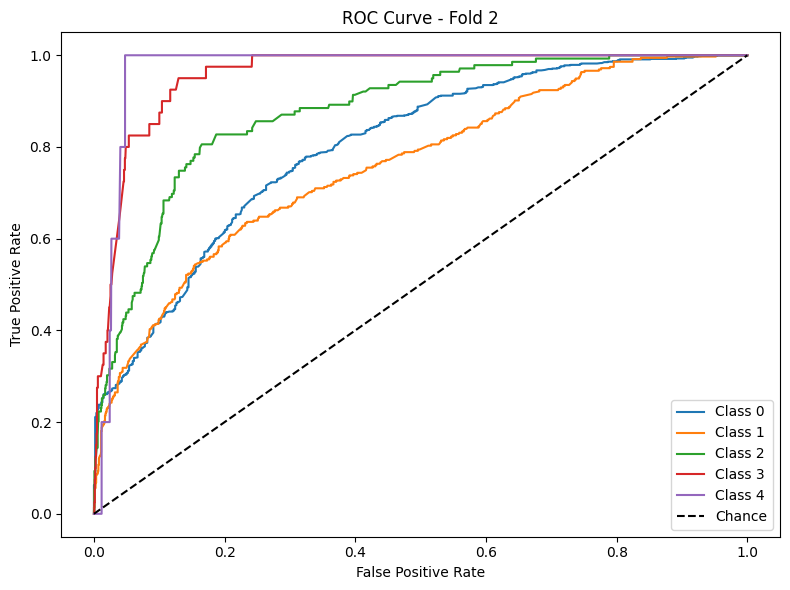

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5850 - loss: 1.6099 - val_accuracy: 0.6485 - val_loss: 1.0160
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6411 - loss: 0.9629 - val_accuracy: 0.6452 - val_loss: 0.9047
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6574 - loss: 0.8824 - val_accuracy: 0.6517 - val_loss: 0.8670
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6643 - loss: 0.8688 - val_accuracy: 0.6628 - val_loss: 0.8177
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6631 - loss: 0.8291 - val_accuracy: 0.6628 - val_loss: 0.7958
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6587 - loss: 0.8551 - val_accuracy: 0.6589 - val_loss: 0.7748
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6704 - loss: 0.8283 - val_accuracy: 0.6725 - val_loss: 0.7834
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6731 - loss: 0.8138 - val_accuracy: 0.6803 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


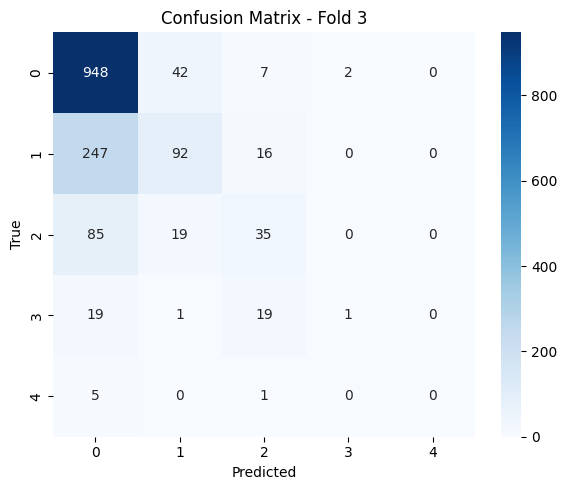

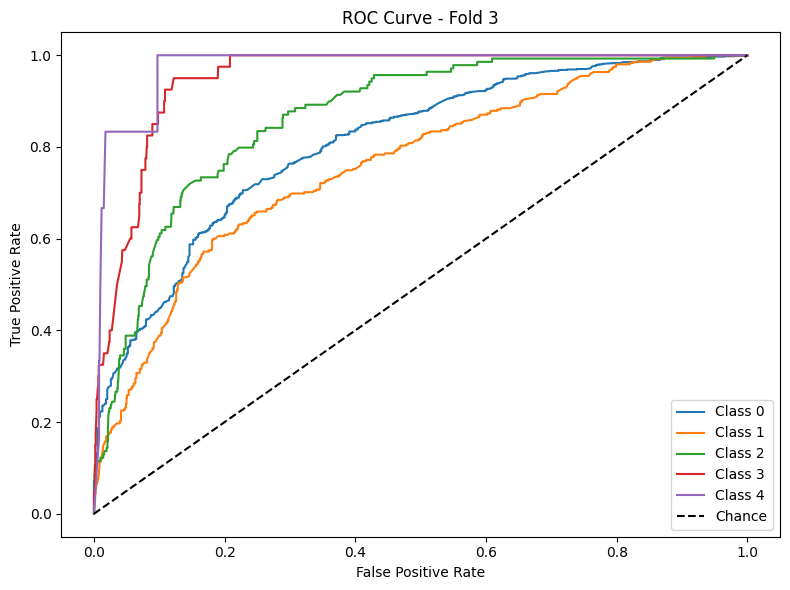

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5753 - loss: 1.5836 - val_accuracy: 0.6515 - val_loss: 0.9250
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6396 - loss: 0.9633 - val_accuracy: 0.6502 - val_loss: 0.9042
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6558 - loss: 0.8983 - val_accuracy: 0.6515 - val_loss: 0.8665
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6461 - loss: 0.8901 - val_accuracy: 0.6612 - val_loss: 0.7989
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6461 - loss: 0.8670 - val_accuracy: 0.6671 - val_loss: 0.7898
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6617 - loss: 0.8259 - val_accuracy: 0.6873 - val_loss: 0.7887
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6510 - loss: 0.8442 - val_accuracy: 0.6736 - val_loss: 0.7780
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6762 - loss: 0.7990 - val_accuracy: 0.6821 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


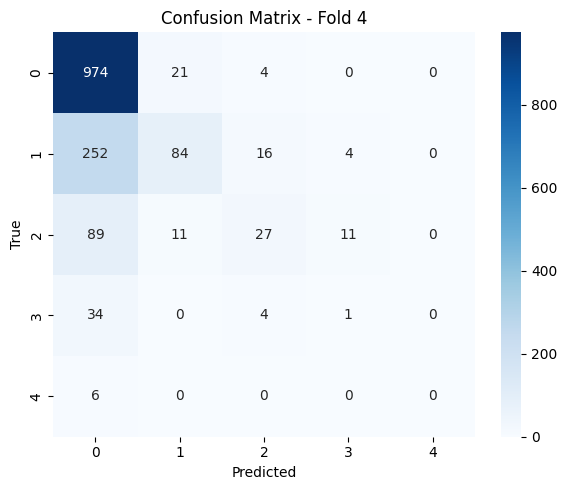

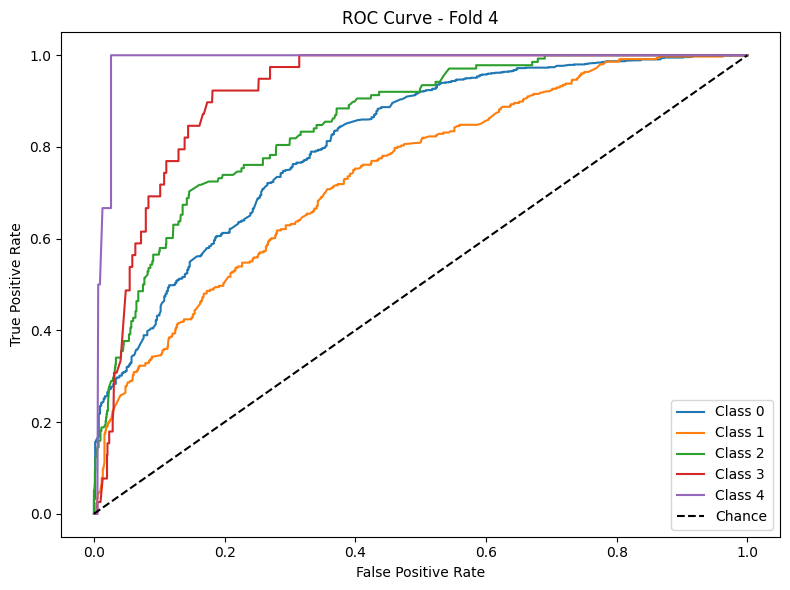

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6020 - loss: 1.5205 - val_accuracy: 0.6424 - val_loss: 0.9569
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6433 - loss: 0.9818 - val_accuracy: 0.6495 - val_loss: 0.9097
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6512 - loss: 0.9172 - val_accuracy: 0.6664 - val_loss: 0.8311
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6641 - loss: 0.8766 - val_accuracy: 0.6678 - val_loss: 0.8118
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6607 - loss: 0.8595 - val_accuracy: 0.6736 - val_loss: 0.7966
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6559 - loss: 0.8473 - val_accuracy: 0.6730 - val_loss: 0.7795
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6675 - loss: 0.8296 - val_accuracy: 0.6762 - val_loss: 0.7739
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6606 - loss: 0.8366 - val_accuracy: 0.6775 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


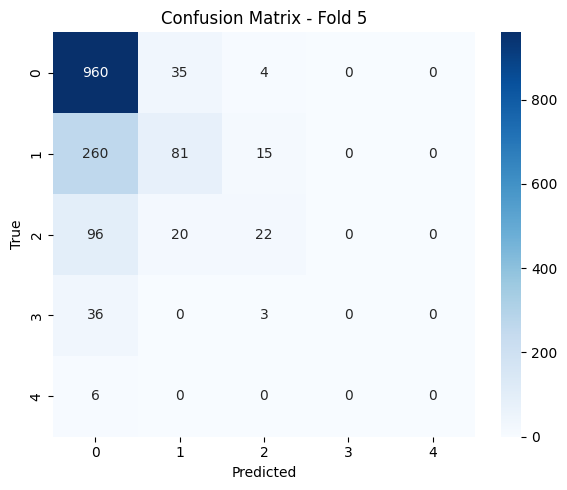

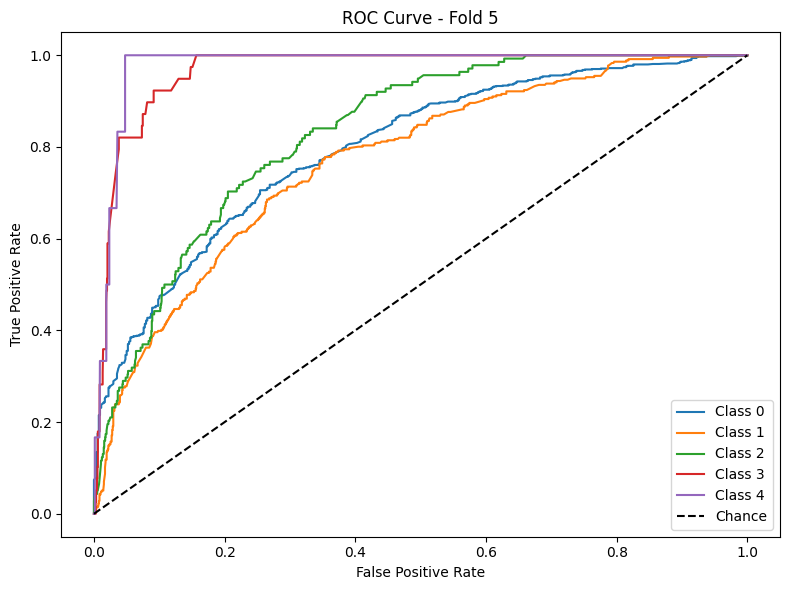


Average Accuracy: 0.7000
Average F1 Macro: 0.3124
Average AUC: 0.8653


In [5]:
# TRAINING ALL PHASES (NO SMOTE)
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"
    
    # Save CNN model (.keras) and scaler
    model.save(f"best_model_{temp}_phase{i}.keras")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics

## Predict on Test Data

In [6]:
def predict_on_test(test_file_path, model_path, scaler_path, school_mapping_file):
    from tensorflow.keras.utils import to_categorical
    import joblib
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
    from tensorflow.keras.models import load_model

    # Load model and scaler từ file
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Load dữ liệu test
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    if 'school' in X_test.columns:
        mapping = joblib.load(school_mapping_file)
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    X_test_scaled = scaler.transform(X_test)
    X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)

    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    y_test_bin = to_categorical(y_test)
    auc_score = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       568
           1       0.22      0.38      0.28        63
           2       0.35      0.21      0.26        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.76       698
   macro avg       0.29      0.29      0.28       698
weighted avg       0.76      0.76      0.76       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


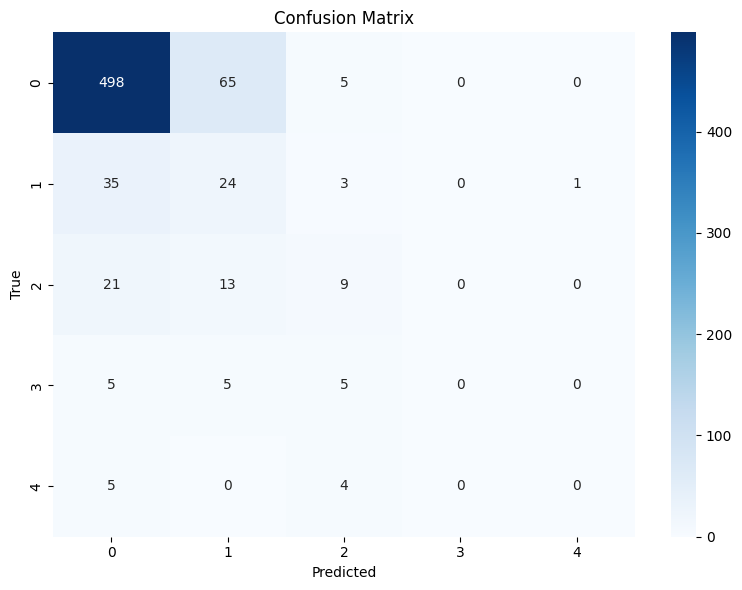


Test AUC (macro-average, OVR): 0.8125


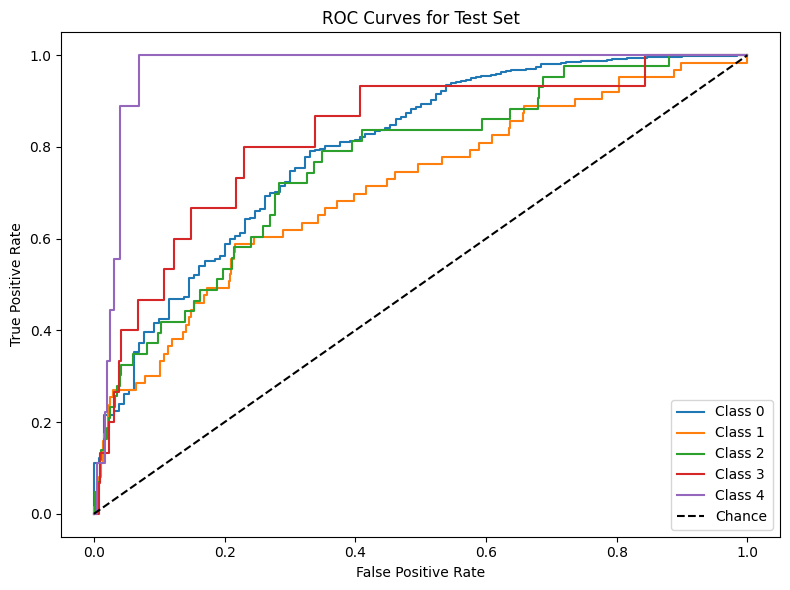

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       544
           1       0.33      0.24      0.28        59
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.24      0.24      0.24       668
weighted avg       0.72      0.81      0.76       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


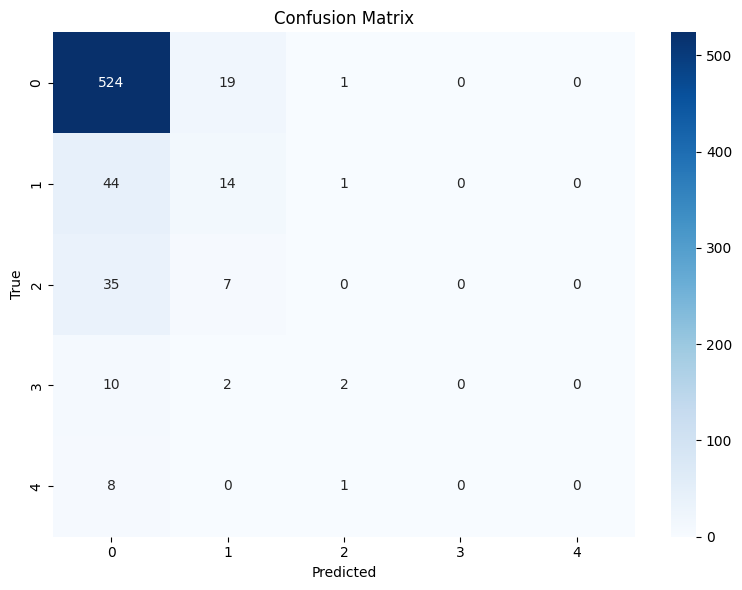


Test AUC (macro-average, OVR): 0.8230


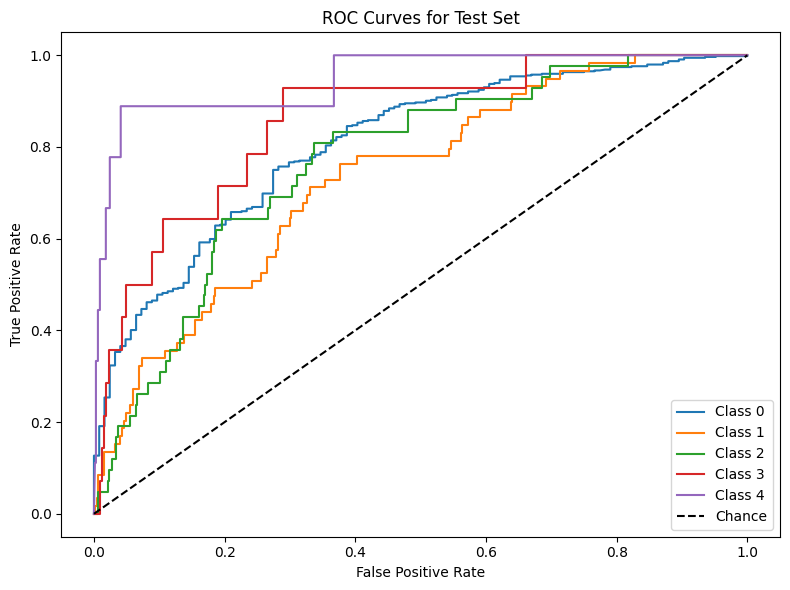

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       455
           1       0.18      0.42      0.25        52
           2       0.44      0.14      0.21        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.71       554
   macro avg       0.30      0.27      0.26       554
weighted avg       0.76      0.71      0.73       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


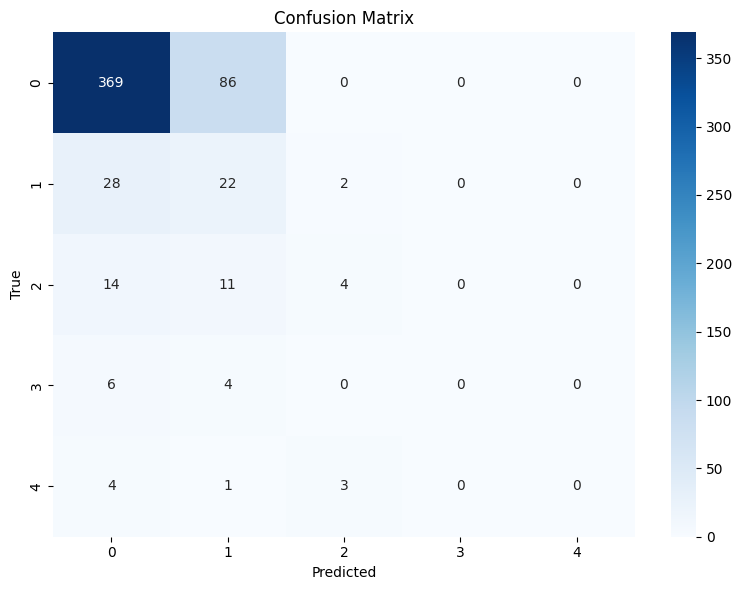


Test AUC (macro-average, OVR): 0.7702


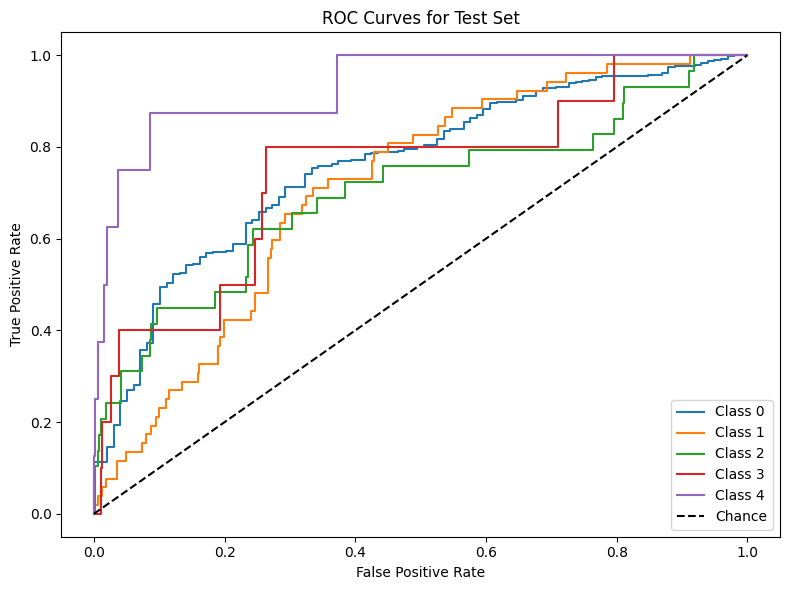

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       395
           1       0.25      0.42      0.32        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.23      0.27      0.24       477
weighted avg       0.75      0.79      0.77       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


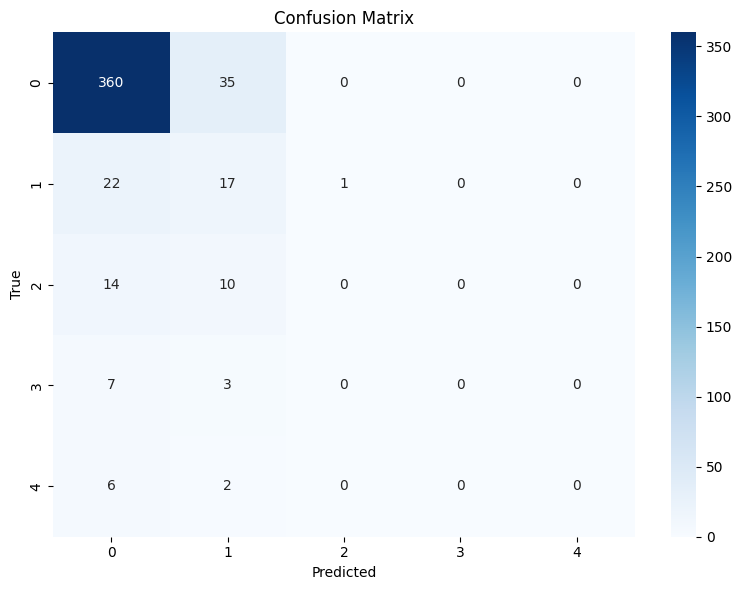


Test AUC (macro-average, OVR): 0.7579


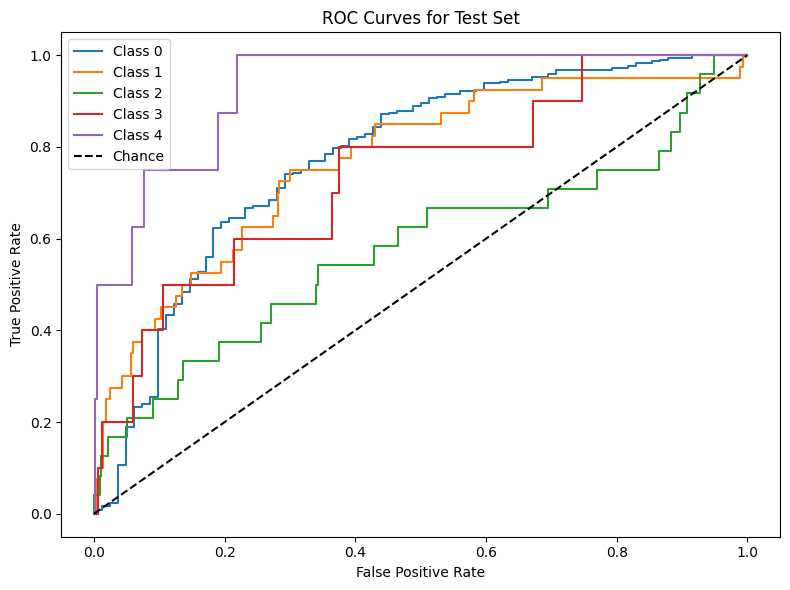

In [7]:
# PREDICT LOOP FOR ALL PHASES (NO SMOTE)
temp = "no_sample"  # Ensure this matches the training config

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Keras model
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.keras'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'
    
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)

# Add SMOTE Sample


=== Training Phase 1 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4843 - loss: 1.3953 - val_accuracy: 0.4331 - val_loss: 1.1037
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5808 - loss: 0.9952 - val_accuracy: 0.5171 - val_loss: 0.9988
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6057 - loss: 0.9372 - val_accuracy: 0.5591 - val_loss: 0.9875
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6190 - loss: 0.9029 - val_accuracy: 0.6081 - val_loss: 0.8915
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6409 - loss: 0.8740 - val_accuracy: 0.5768 - val_loss: 0.9922
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6400 - loss: 0.8710 - val_accuracy: 0.5698 - val_loss: 1.0492
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6529 - loss: 0.8471 - val_accuracy: 0.5982 - val_loss: 0.9250
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6552 - loss: 0.8313 - val_accuracy: 0.5971 - val_

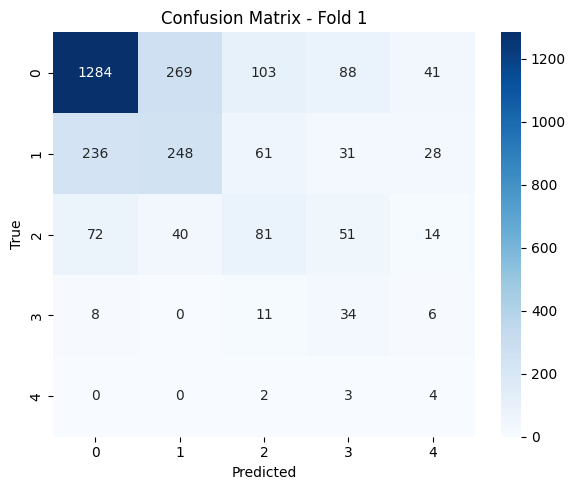

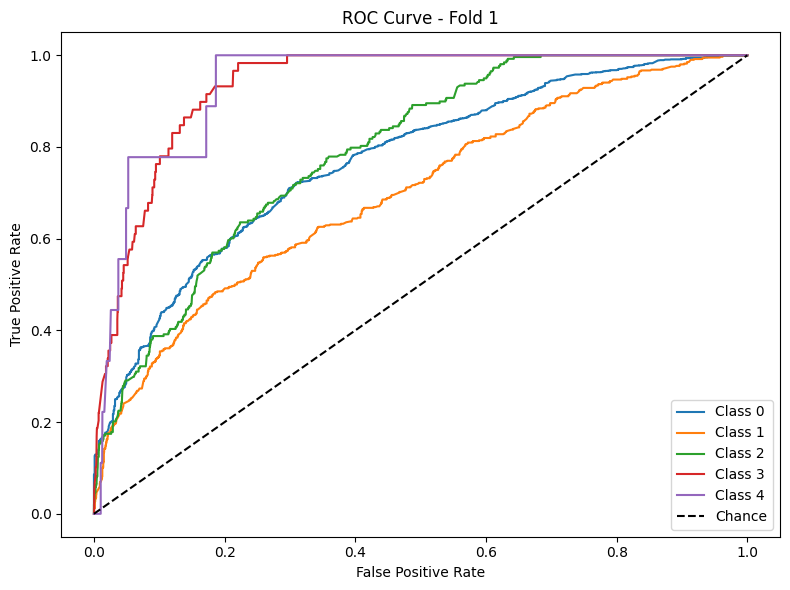

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4970 - loss: 1.3538 - val_accuracy: 0.4702 - val_loss: 1.0733
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6108 - loss: 0.9462 - val_accuracy: 0.4576 - val_loss: 1.1012
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6388 - loss: 0.8881 - val_accuracy: 0.5671 - val_loss: 0.9922
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6464 - loss: 0.8710 - val_accuracy: 0.5648 - val_loss: 1.0257
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6557 - loss: 0.8479 - val_accuracy: 0.5575 - val_loss: 0.9758
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6642 - loss: 0.8282 - val_accuracy: 0.5789 - val_loss: 0.9460
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6693 - loss: 0.8340 - val_accuracy: 0.5582 - val_loss: 1.0307
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6765 - loss: 0.8084 - val_accuracy: 0.5917 - val

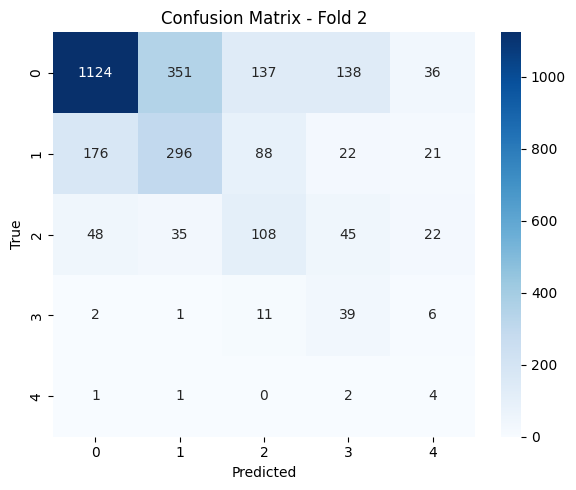

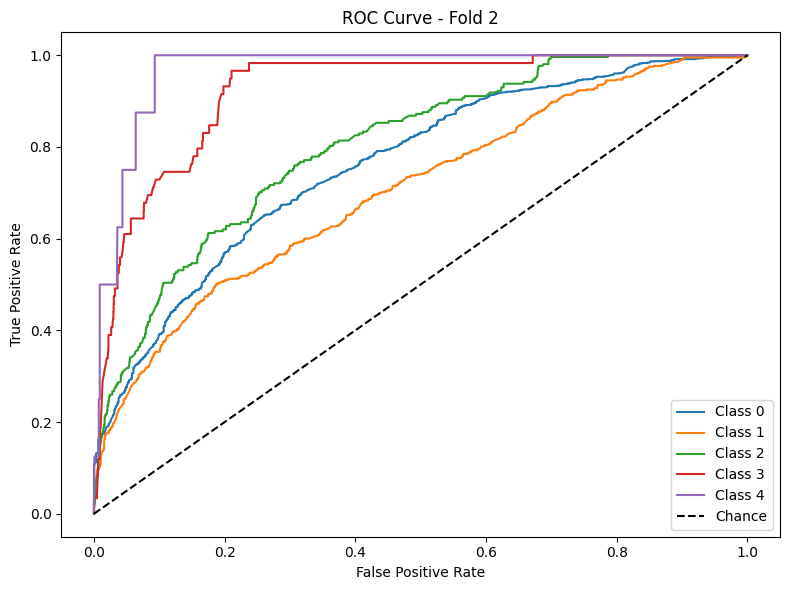

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4741 - loss: 1.4213 - val_accuracy: 0.5391 - val_loss: 1.0214
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5946 - loss: 0.9668 - val_accuracy: 0.5630 - val_loss: 1.0136
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6194 - loss: 0.9070 - val_accuracy: 0.5866 - val_loss: 0.9437
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6264 - loss: 0.8883 - val_accuracy: 0.5545 - val_loss: 1.0022
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6432 - loss: 0.8551 - val_accuracy: 0.5700 - val_loss: 0.9390
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6497 - loss: 0.8457 - val_accuracy: 0.5501 - val_loss: 0.9856
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6565 - loss: 0.8288 - val_accuracy: 0.5637 - val_loss: 0.9740
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6613 - loss: 0.8266 - val_accuracy: 0.5409 - val

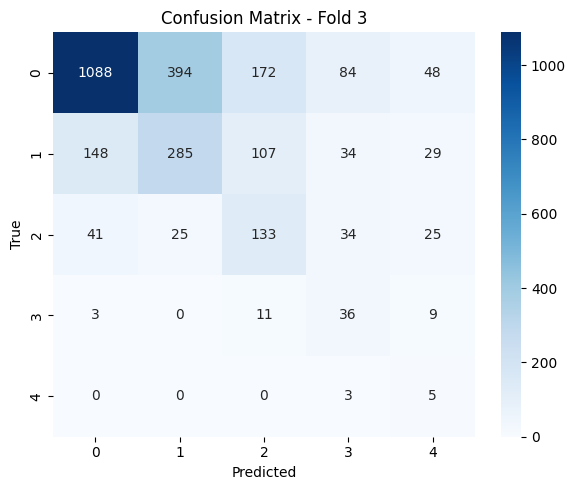

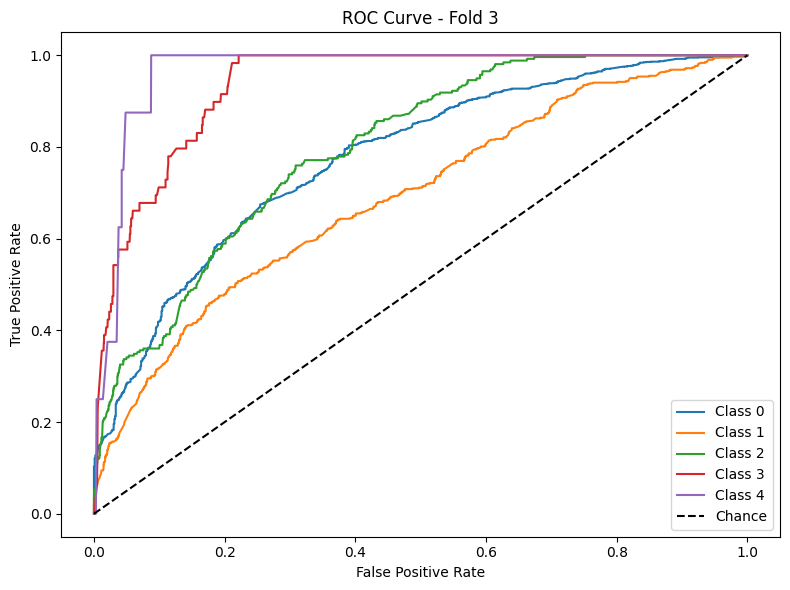

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4859 - loss: 1.3944 - val_accuracy: 0.4867 - val_loss: 1.0839
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6008 - loss: 0.9521 - val_accuracy: 0.5453 - val_loss: 1.0019
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6285 - loss: 0.9064 - val_accuracy: 0.5626 - val_loss: 0.9852
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6412 - loss: 0.8674 - val_accuracy: 0.5711 - val_loss: 0.9474
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6442 - loss: 0.8506 - val_accuracy: 0.5748 - val_loss: 0.9750
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6584 - loss: 0.8368 - val_accuracy: 0.5648 - val_loss: 0.9831
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6621 - loss: 0.8199 - val_accuracy: 0.6139 - val_loss: 0.8916
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6685 - loss: 0.8081 - val_accuracy: 0.6054 - val_

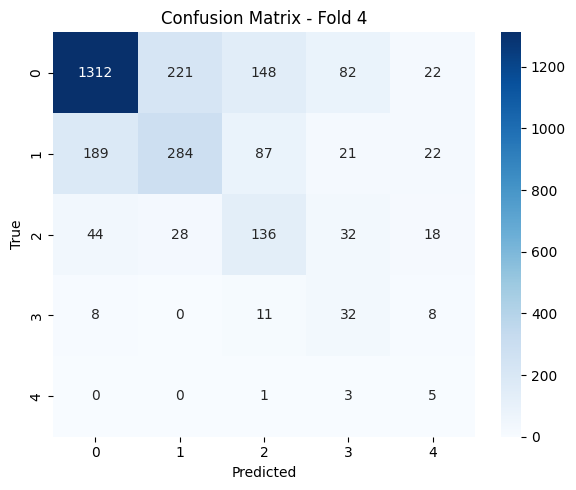

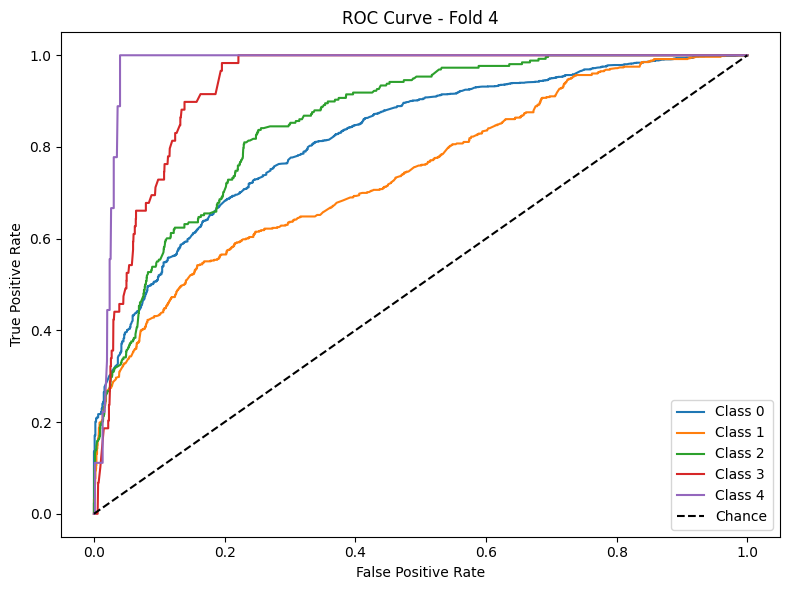

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4834 - loss: 1.3798 - val_accuracy: 0.5571 - val_loss: 1.0221
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6018 - loss: 0.9501 - val_accuracy: 0.5151 - val_loss: 1.0052
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6313 - loss: 0.8980 - val_accuracy: 0.5718 - val_loss: 1.0115
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6417 - loss: 0.8724 - val_accuracy: 0.5840 - val_loss: 0.9466
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6582 - loss: 0.8482 - val_accuracy: 0.5910 - val_loss: 0.9467
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6596 - loss: 0.8357 - val_accuracy: 0.5774 - val_loss: 0.9577
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6624 - loss: 0.8287 - val_accuracy: 0.5542 - val_loss: 0.9917
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6739 - loss: 0.8118 - val_accuracy: 0.5906 - val_

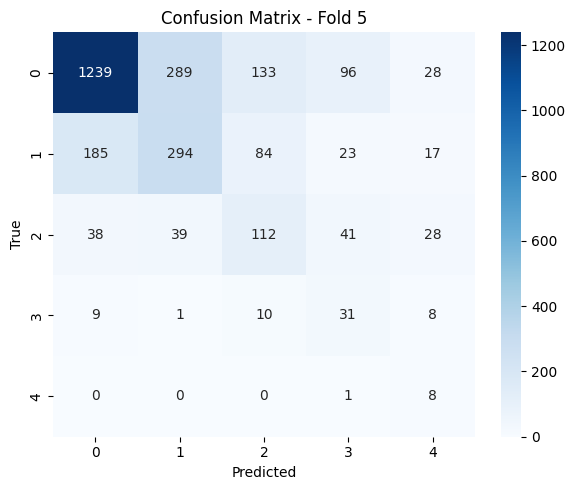

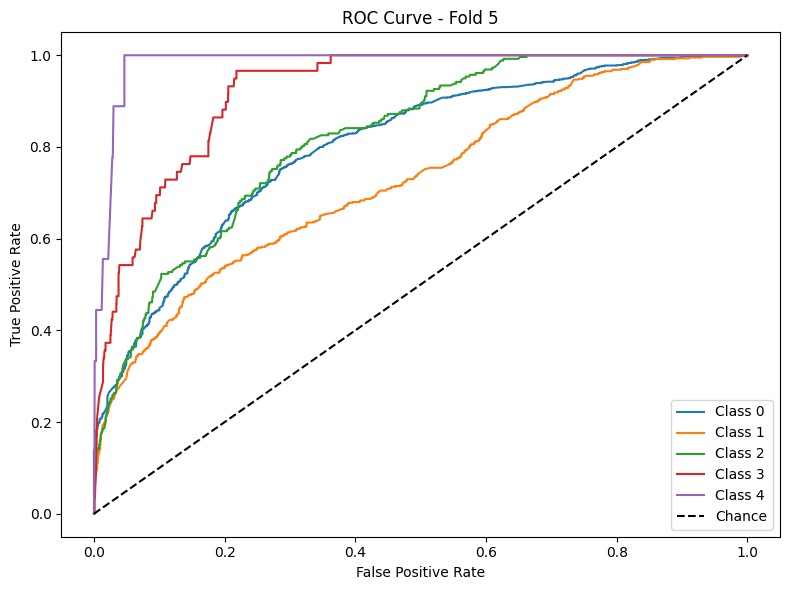


Average Accuracy: 0.6059
Average F1 Macro: 0.3899
Average AUC: 0.8417

=== Training Phase 2 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4890 - loss: 1.5036 - val_accuracy: 0.5438 - val_loss: 1.0742
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6141 - loss: 0.9468 - val_accuracy: 0.5137 - val_loss: 1.0864
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6277 - loss: 0.9007 - val_accuracy: 0.6115 - val_loss: 0.9381
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6519 - loss: 0.8621 - val_accuracy: 0.5146 - val_loss: 1.0545
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6521 - loss: 0.8482 - val_accuracy: 0.5907 - val_loss: 0.9409
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6646 - loss: 0.8150 - val_accuracy: 0.5562 - val_loss: 1.0036
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6685 - loss: 0.8077 - val_accuracy: 0.6106 - val_loss: 0.9259
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6690 - loss: 0.8162 - val_accuracy: 0.6336 - val

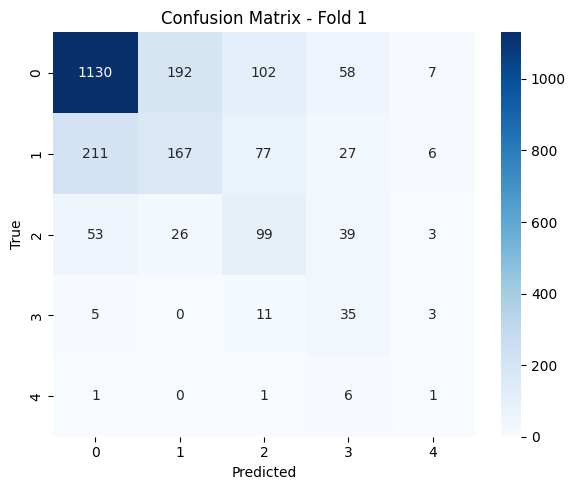

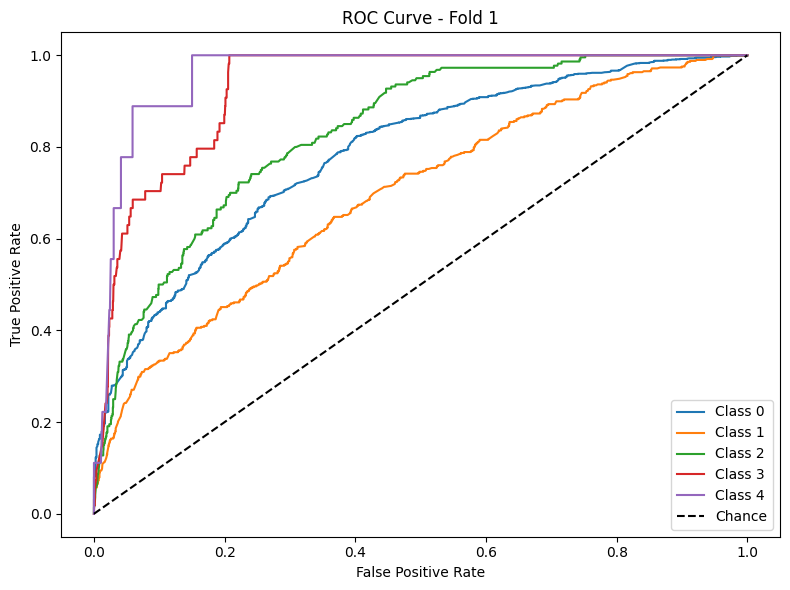

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4835 - loss: 1.4931 - val_accuracy: 0.4819 - val_loss: 1.0558
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6080 - loss: 0.9710 - val_accuracy: 0.5611 - val_loss: 0.9761
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6290 - loss: 0.9027 - val_accuracy: 0.5456 - val_loss: 0.9821
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6459 - loss: 0.8655 - val_accuracy: 0.5695 - val_loss: 0.9764
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6573 - loss: 0.8394 - val_accuracy: 0.5239 - val_loss: 1.0243
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6683 - loss: 0.8173 - val_accuracy: 0.5783 - val_loss: 0.9336
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6746 - loss: 0.8031 - val_accuracy: 0.5872 - val_loss: 0.9725
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6694 - loss: 0.8039 - val_accuracy: 0.5659 - val

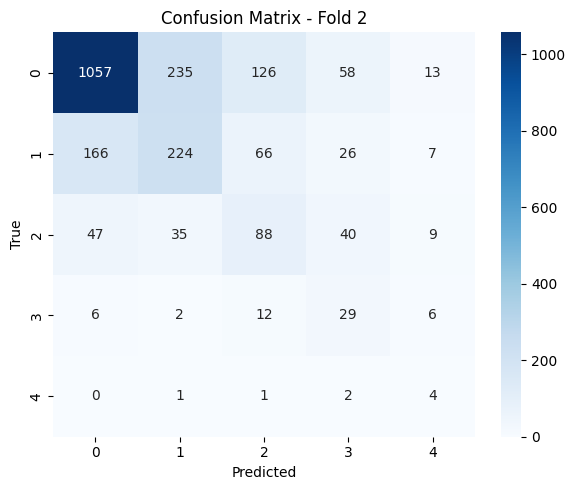

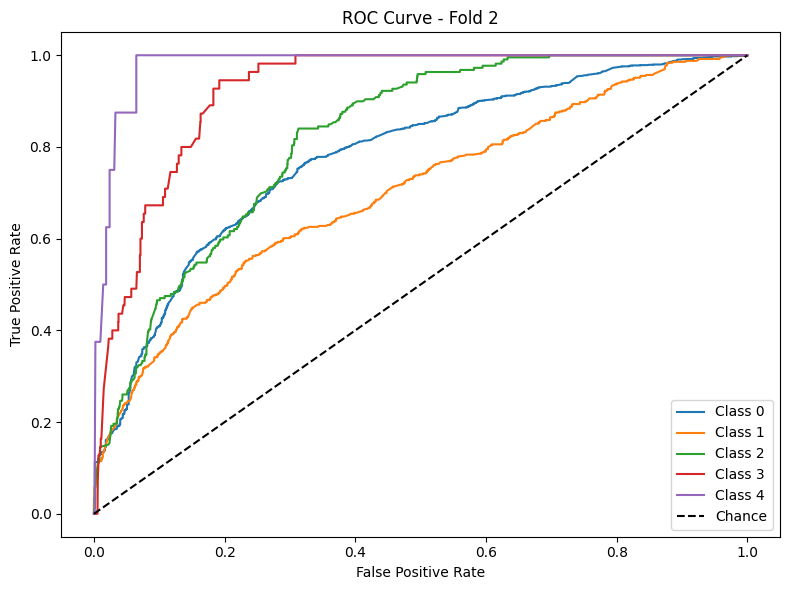

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5057 - loss: 1.4362 - val_accuracy: 0.5241 - val_loss: 1.0228
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6200 - loss: 0.9303 - val_accuracy: 0.4498 - val_loss: 1.1350
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6358 - loss: 0.8868 - val_accuracy: 0.5082 - val_loss: 1.1710
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6623 - loss: 0.8419 - val_accuracy: 0.5383 - val_loss: 1.0931
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6616 - loss: 0.8272 - val_accuracy: 0.5476 - val_loss: 1.0288
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6748 - loss: 0.8046 - val_accuracy: 0.5533 - val_loss: 1.0868
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.58      0.67      1489
           1       0.36      0.37      0.37       489
        

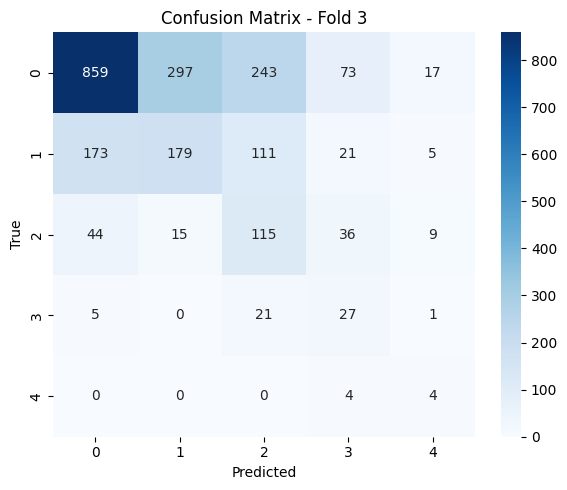

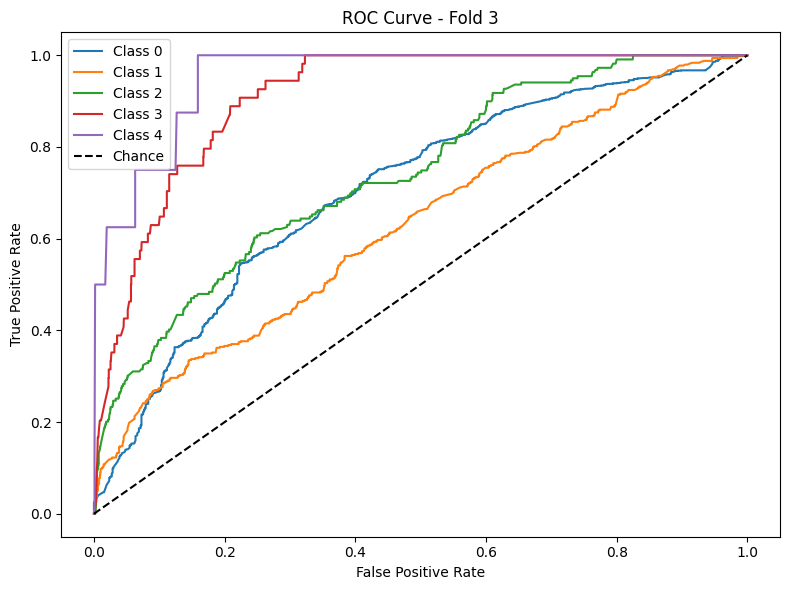

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4521 - loss: 1.5479 - val_accuracy: 0.5454 - val_loss: 0.9879
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5894 - loss: 1.0057 - val_accuracy: 0.4869 - val_loss: 1.0869
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6159 - loss: 0.9506 - val_accuracy: 0.4843 - val_loss: 1.0790
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6303 - loss: 0.9144 - val_accuracy: 0.5600 - val_loss: 1.0200
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6389 - loss: 0.8923 - val_accuracy: 0.5498 - val_loss: 1.0455
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6409 - loss: 0.8746 - val_accuracy: 0.6073 - val_loss: 0.9627
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6637 - loss: 0.8492 - val_accuracy: 0.6087 - val_loss: 0.9227
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6606 - loss: 0.8392 - val_accuracy: 0.5981 - val

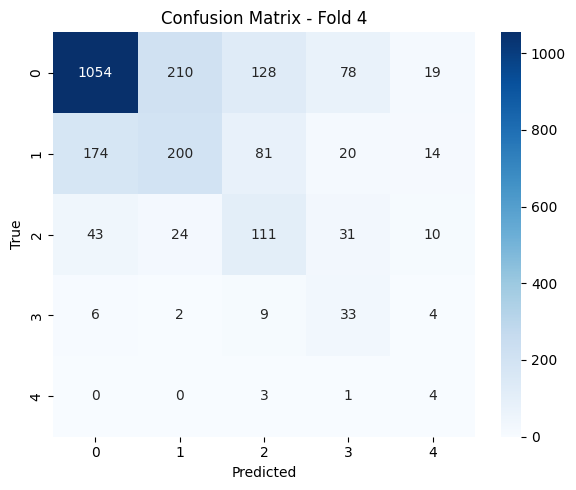

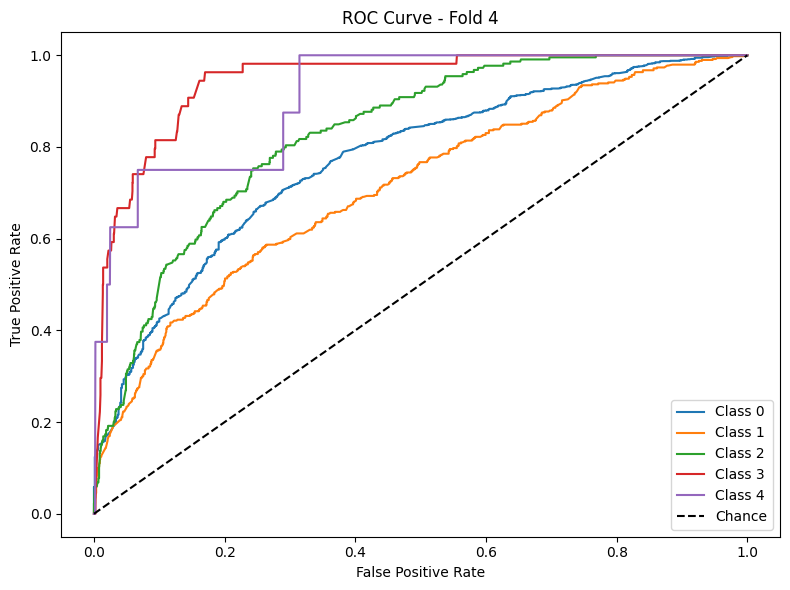

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4853 - loss: 1.4563 - val_accuracy: 0.5281 - val_loss: 1.0437
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6159 - loss: 0.9665 - val_accuracy: 0.5064 - val_loss: 1.1178
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6385 - loss: 0.9044 - val_accuracy: 0.5817 - val_loss: 0.9616
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6438 - loss: 0.8780 - val_accuracy: 0.5662 - val_loss: 0.9883
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6582 - loss: 0.8551 - val_accuracy: 0.5790 - val_loss: 0.9867
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6600 - loss: 0.8434 - val_accuracy: 0.5684 - val_loss: 0.9651
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6736 - loss: 0.8142 - val_accuracy: 0.5728 - val_loss: 0.9687
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6744 - loss: 0.8109 - val_accuracy: 0.6109 - val

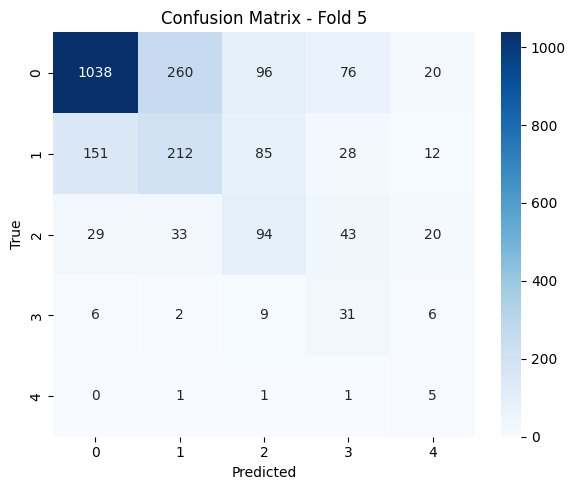

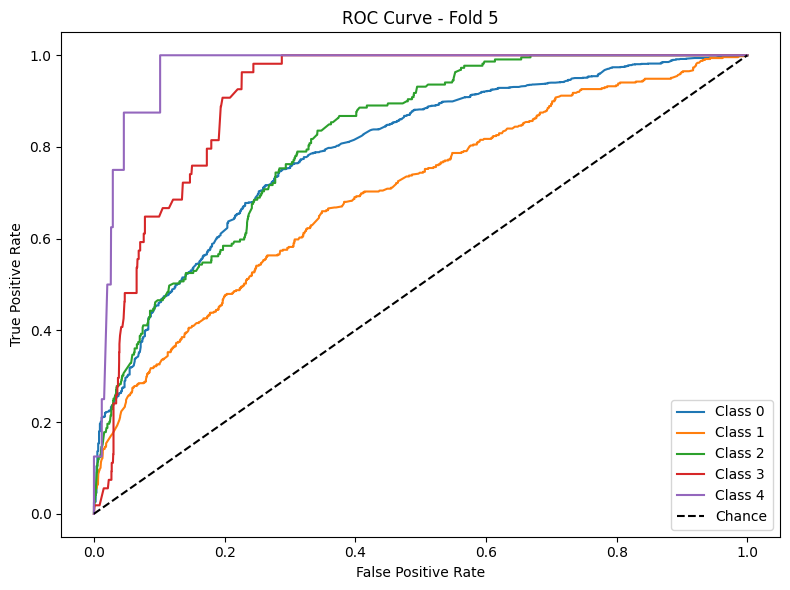


Average Accuracy: 0.6019
Average F1 Macro: 0.3900
Average AUC: 0.8279

=== Training Phase 3 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4750 - loss: 1.5654 - val_accuracy: 0.3288 - val_loss: 1.2854
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6064 - loss: 0.9612 - val_accuracy: 0.5468 - val_loss: 1.1158
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6378 - loss: 0.8941 - val_accuracy: 0.5246 - val_loss: 1.1278
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6539 - loss: 0.8573 - val_accuracy: 0.5824 - val_loss: 0.9655
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6671 - loss: 0.8332 - val_accuracy: 0.5815 - val_loss: 1.0263
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6704 - loss: 0.8310 - val_accuracy: 0.5926 - val_loss: 1.0032
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6766 - loss: 0.8166 - val_accuracy: 0.5911 - val_loss: 1.0253
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6794 - loss: 0.8076 - val_accuracy: 0.5796 - val

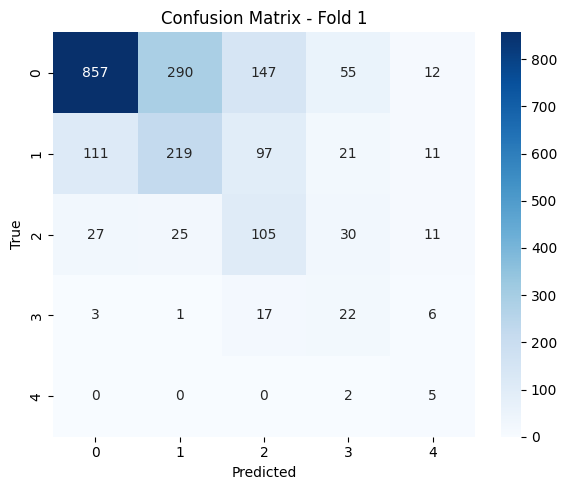

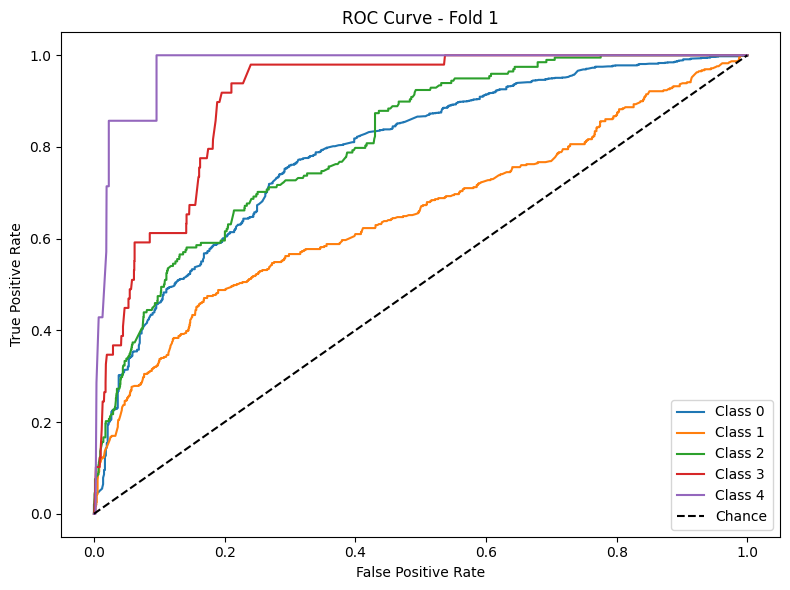

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4785 - loss: 1.5363 - val_accuracy: 0.5034 - val_loss: 1.0934
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6031 - loss: 0.9833 - val_accuracy: 0.5140 - val_loss: 1.0620
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6333 - loss: 0.9077 - val_accuracy: 0.5362 - val_loss: 1.0082
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6445 - loss: 0.8768 - val_accuracy: 0.5468 - val_loss: 1.0155
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6515 - loss: 0.8660 - val_accuracy: 0.5304 - val_loss: 1.0528
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6573 - loss: 0.8412 - val_accuracy: 0.6205 - val_loss: 0.9330
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6692 - loss: 0.8283 - val_accuracy: 0.6133 - val_loss: 0.9399
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6687 - loss: 0.8275 - val_accuracy: 0.5612 - val

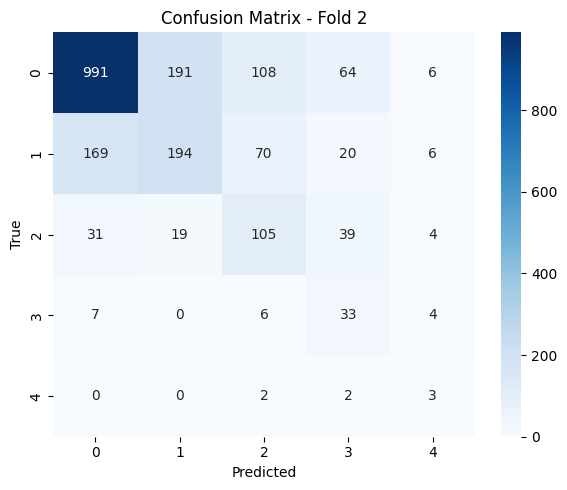

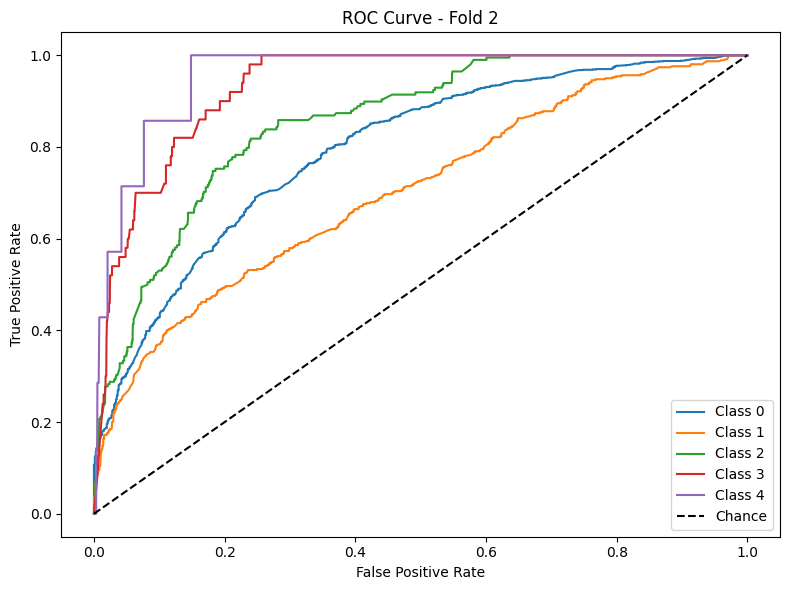

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4754 - loss: 1.6047 - val_accuracy: 0.5280 - val_loss: 0.9918
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6014 - loss: 0.9895 - val_accuracy: 0.4932 - val_loss: 1.0626
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6248 - loss: 0.9199 - val_accuracy: 0.5309 - val_loss: 0.9772
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6466 - loss: 0.8798 - val_accuracy: 0.5400 - val_loss: 1.0550
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6497 - loss: 0.8559 - val_accuracy: 0.5535 - val_loss: 1.0525
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6668 - loss: 0.8365 - val_accuracy: 0.5492 - val_loss: 1.0194
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6650 - loss: 0.8374 - val_accuracy: 0.5564 - val_loss: 0.9998
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6667 - loss: 0.8277 - val_accuracy: 0.5767 - val

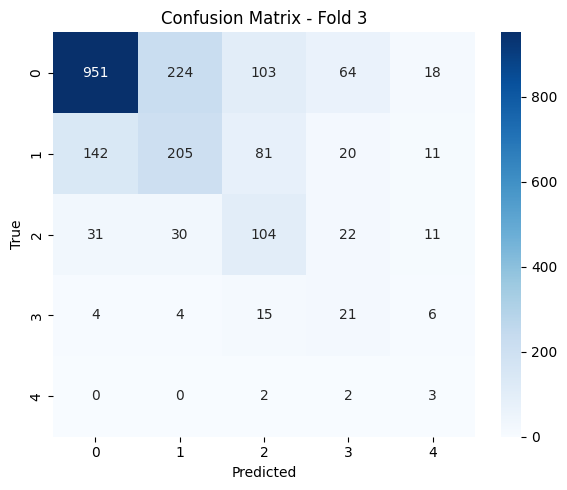

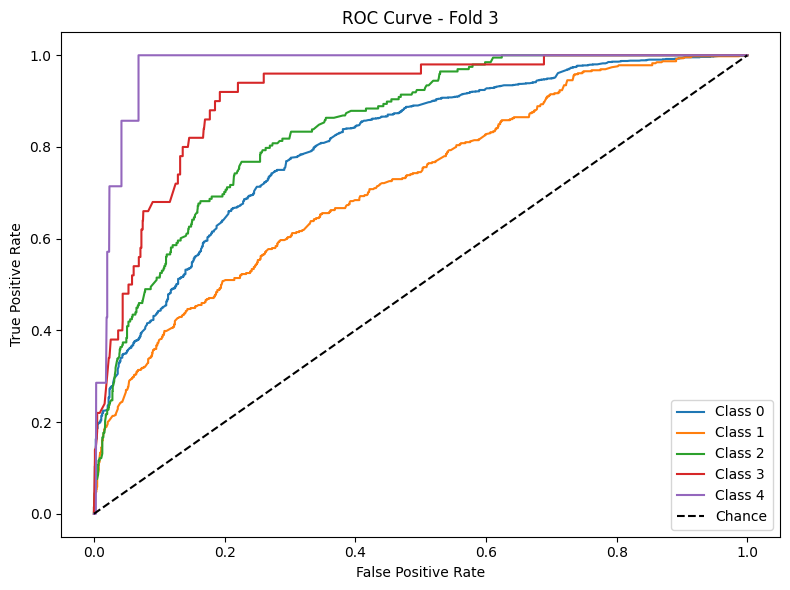

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4829 - loss: 1.5365 - val_accuracy: 0.5501 - val_loss: 0.9912
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6111 - loss: 0.9714 - val_accuracy: 0.4894 - val_loss: 1.1089
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6389 - loss: 0.9114 - val_accuracy: 0.5405 - val_loss: 1.0225
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6415 - loss: 0.8811 - val_accuracy: 0.5858 - val_loss: 0.9507
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6543 - loss: 0.8663 - val_accuracy: 0.5849 - val_loss: 1.0251
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6713 - loss: 0.8357 - val_accuracy: 0.5718 - val_loss: 1.0509
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6742 - loss: 0.8257 - val_accuracy: 0.5781 - val_loss: 1.0237
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6826 - loss: 0.8189 - val_accuracy: 0.6148 - val

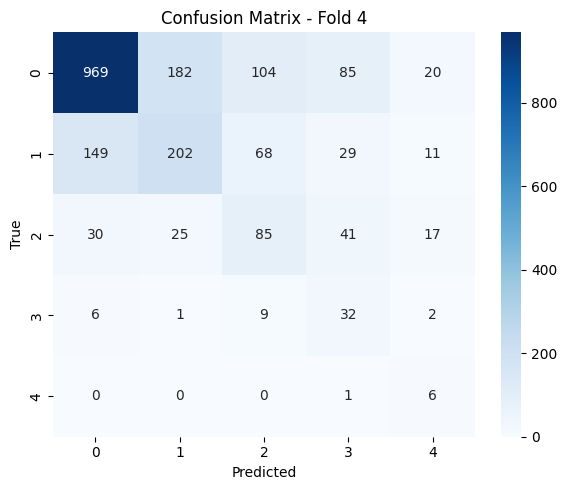

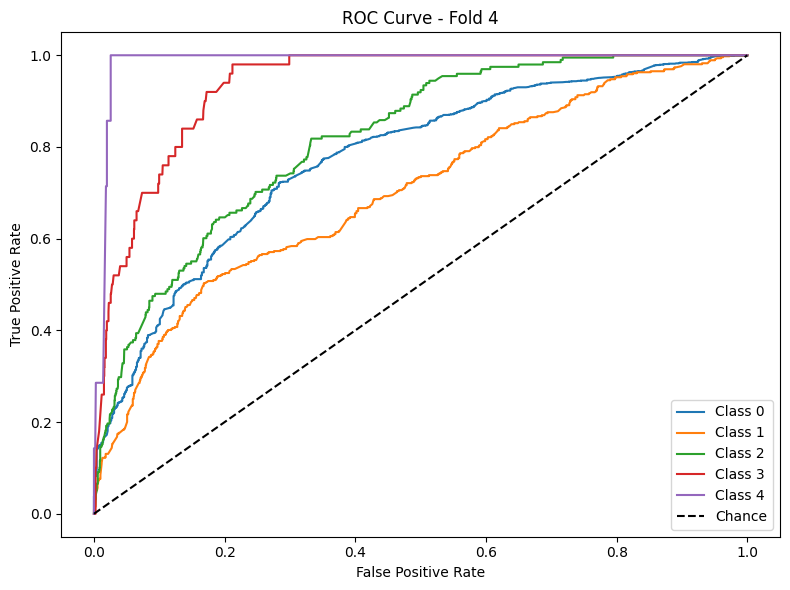

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4920 - loss: 1.5212 - val_accuracy: 0.5027 - val_loss: 1.0826
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6196 - loss: 0.9354 - val_accuracy: 0.4062 - val_loss: 1.3133
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6536 - loss: 0.8750 - val_accuracy: 0.5683 - val_loss: 1.0177
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6594 - loss: 0.8374 - val_accuracy: 0.5842 - val_loss: 1.0175
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6720 - loss: 0.8146 - val_accuracy: 0.5779 - val_loss: 1.0033
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6708 - loss: 0.8074 - val_accuracy: 0.6073 - val_loss: 0.9524
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6837 - loss: 0.7901 - val_accuracy: 0.5866 - val_loss: 1.0447
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6891 - loss: 0.7822 - val_accuracy: 0.5697 - val

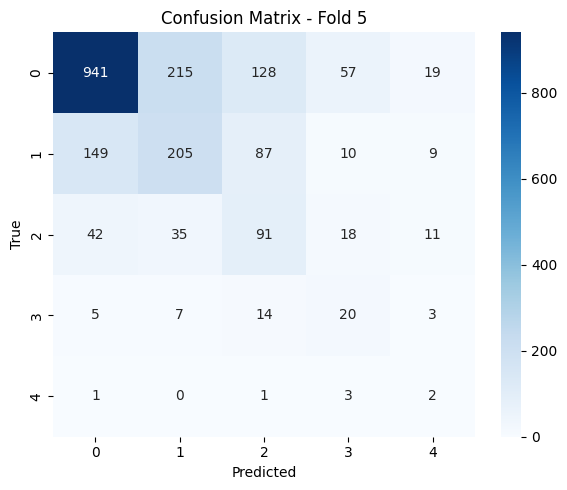

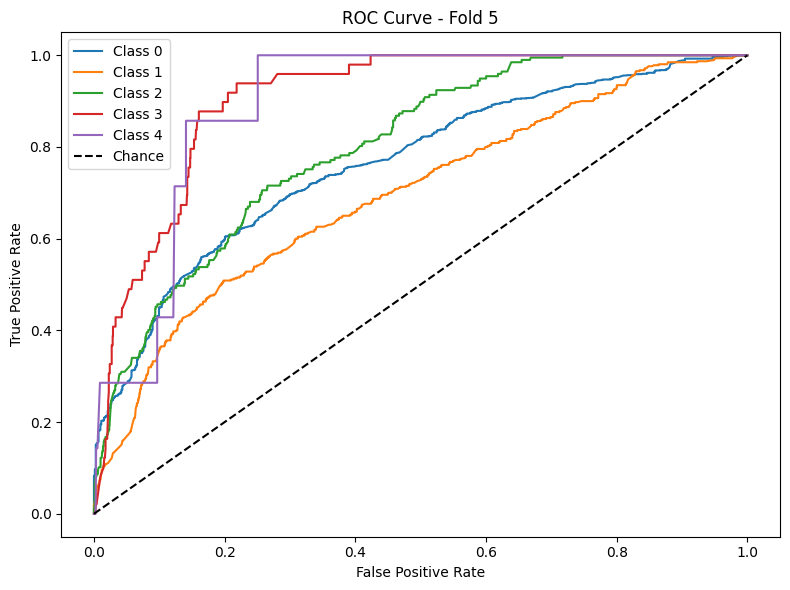


Average Accuracy: 0.6144
Average F1 Macro: 0.4023
Average AUC: 0.8363

=== Training Phase 4 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4828 - loss: 1.5410 - val_accuracy: 0.3736 - val_loss: 1.2310
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5984 - loss: 0.9879 - val_accuracy: 0.5348 - val_loss: 1.0547
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6258 - loss: 0.9174 - val_accuracy: 0.4964 - val_loss: 1.1136
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6521 - loss: 0.8621 - val_accuracy: 0.5029 - val_loss: 1.0378
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6594 - loss: 0.8356 - val_accuracy: 0.5588 - val_loss: 1.0218
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6670 - loss: 0.8123 - val_accuracy: 0.5660 - val_loss: 1.0140
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6743 - loss: 0.8081 - val_accuracy: 0.6049 - val_loss: 0.9426
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6901 - loss: 0.7770 - val_accuracy: 0.5211 - val

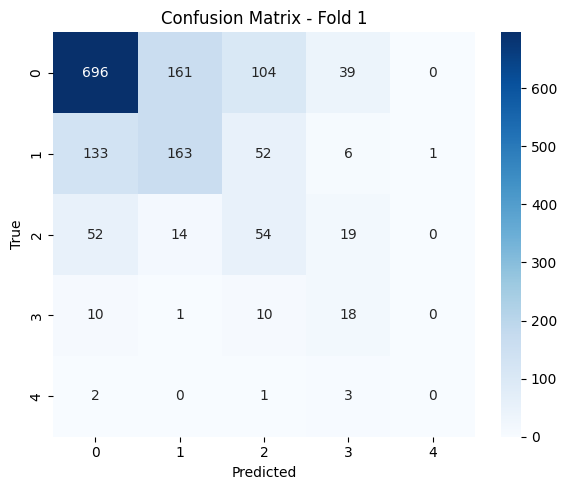

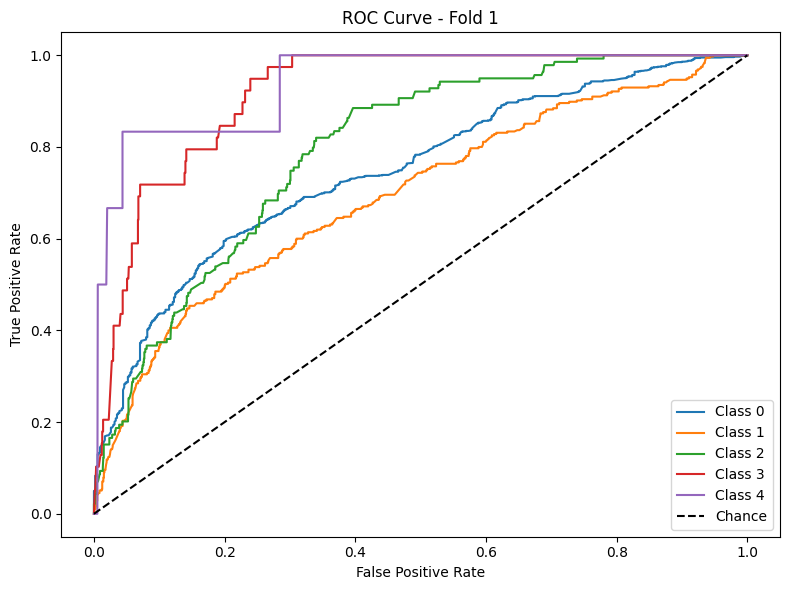

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4755 - loss: 1.5651 - val_accuracy: 0.3892 - val_loss: 1.1822
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6302 - loss: 0.9276 - val_accuracy: 0.5562 - val_loss: 1.0083
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6542 - loss: 0.8758 - val_accuracy: 0.5276 - val_loss: 0.9711
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6733 - loss: 0.8247 - val_accuracy: 0.5757 - val_loss: 0.9347
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6711 - loss: 0.8280 - val_accuracy: 0.5705 - val_loss: 0.9534
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6869 - loss: 0.7945 - val_accuracy: 0.5673 - val_loss: 0.9439
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7006 - loss: 0.7621 - val_accuracy: 0.5523 - val_loss: 0.9542
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7032 - loss: 0.7500 - val_accuracy: 0.5374 - va

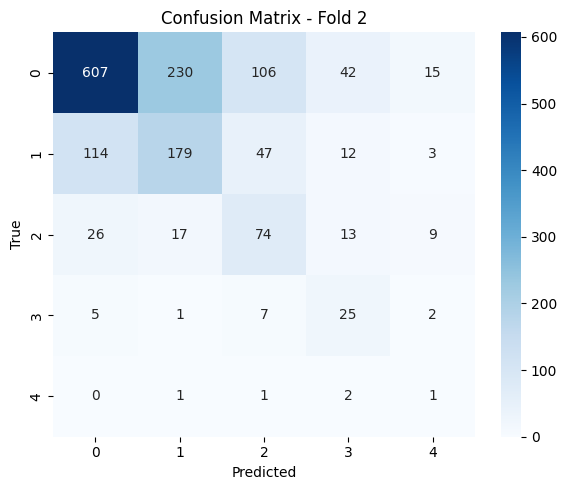

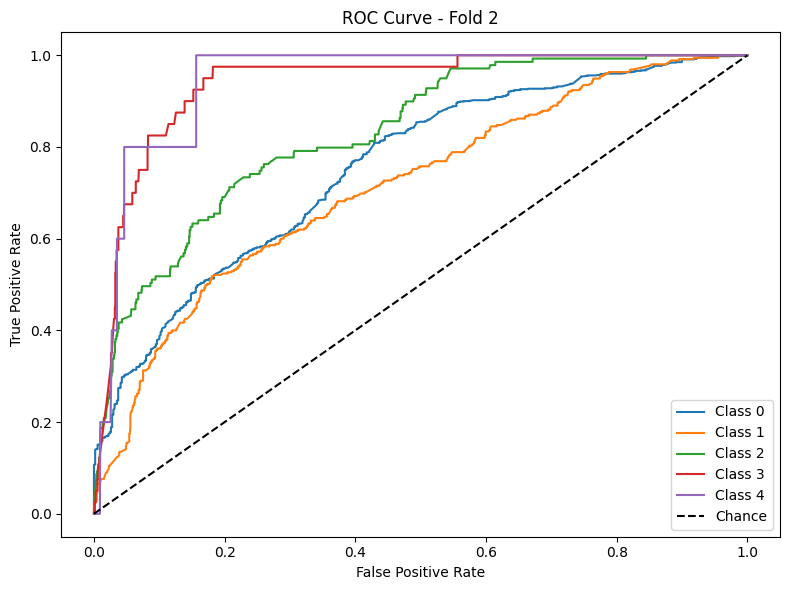

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4791 - loss: 1.5133 - val_accuracy: 0.4003 - val_loss: 1.1828
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6185 - loss: 0.9467 - val_accuracy: 0.5530 - val_loss: 1.0146
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6468 - loss: 0.8914 - val_accuracy: 0.5120 - val_loss: 1.0826
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6671 - loss: 0.8438 - val_accuracy: 0.5302 - val_loss: 1.0278
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6769 - loss: 0.8194 - val_accuracy: 0.5783 - val_loss: 0.9833
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6726 - loss: 0.8122 - val_accuracy: 0.5452 - val_loss: 1.0575
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6857 - loss: 0.7861 - val_accuracy: 0.4561 - val_loss: 1.3437
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6936 - loss: 0.7710 - val_accuracy: 0.5023 - va

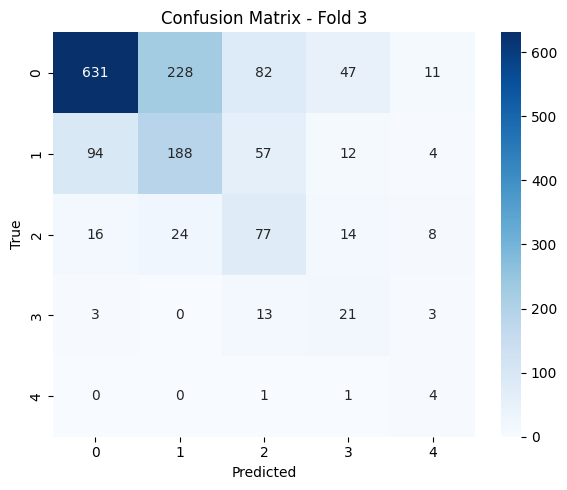

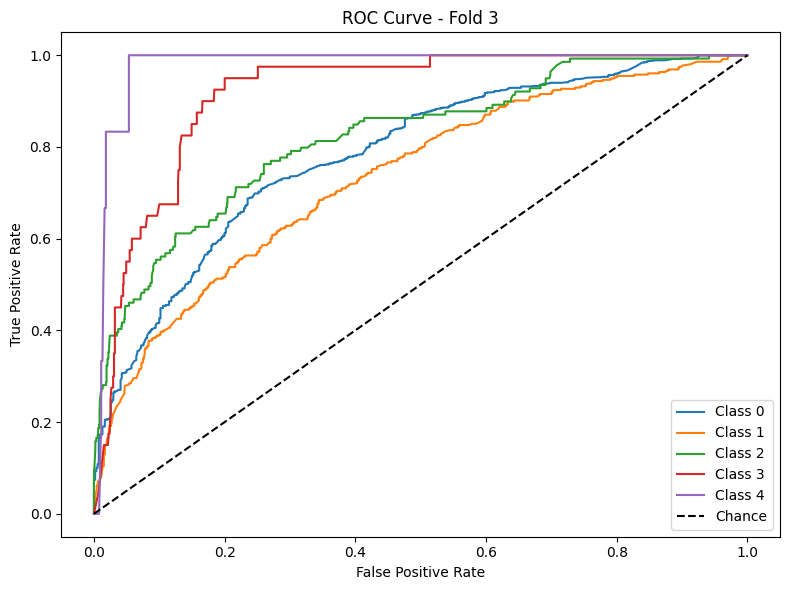

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4952 - loss: 1.5540 - val_accuracy: 0.5117 - val_loss: 1.0497
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6209 - loss: 0.9635 - val_accuracy: 0.6073 - val_loss: 0.9713
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6573 - loss: 0.8807 - val_accuracy: 0.5338 - val_loss: 1.0703
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6639 - loss: 0.8449 - val_accuracy: 0.5494 - val_loss: 0.9860
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6728 - loss: 0.8335 - val_accuracy: 0.6112 - val_loss: 0.9964
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6890 - loss: 0.7976 - val_accuracy: 0.5338 - val_loss: 1.0698
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6886 - loss: 0.7865 - val_accuracy: 0.5371 - val_loss: 0.9808
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 4 Classification Report:
               precision    recall  f1-score

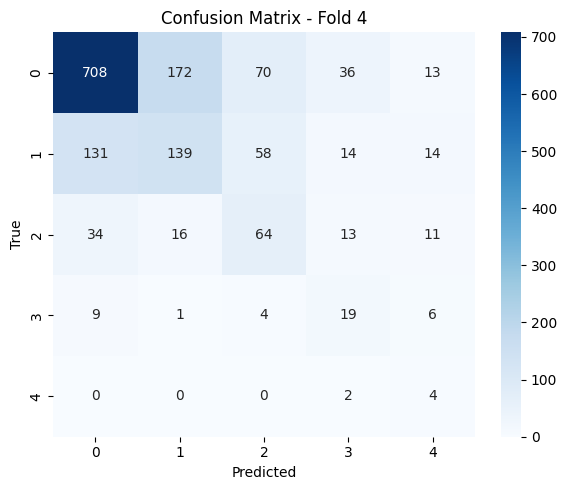

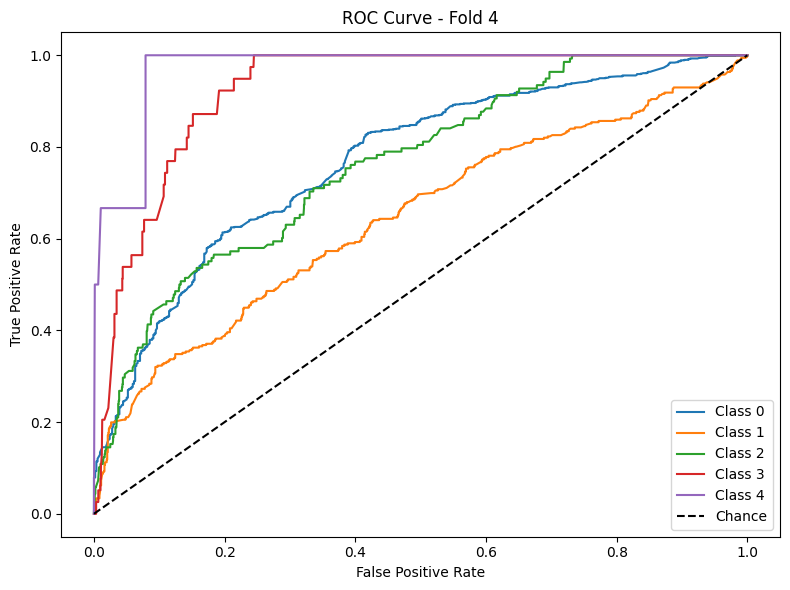

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4898 - loss: 1.5721 - val_accuracy: 0.4018 - val_loss: 1.0971
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6440 - loss: 0.9187 - val_accuracy: 0.4142 - val_loss: 1.2638
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6702 - loss: 0.8324 - val_accuracy: 0.5780 - val_loss: 0.9985
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6663 - loss: 0.8298 - val_accuracy: 0.5878 - val_loss: 0.9910
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6855 - loss: 0.7937 - val_accuracy: 0.6118 - val_loss: 0.9776
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6902 - loss: 0.7809 - val_accuracy: 0.5754 - val_loss: 1.0431
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6993 - loss: 0.7712 - val_accuracy: 0.5657 - val_loss: 1.0200
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7129 - loss: 0.7364 - val_accuracy: 0.6216 - val

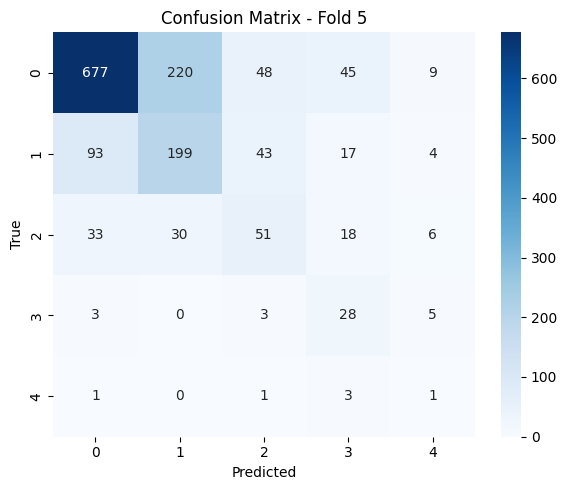

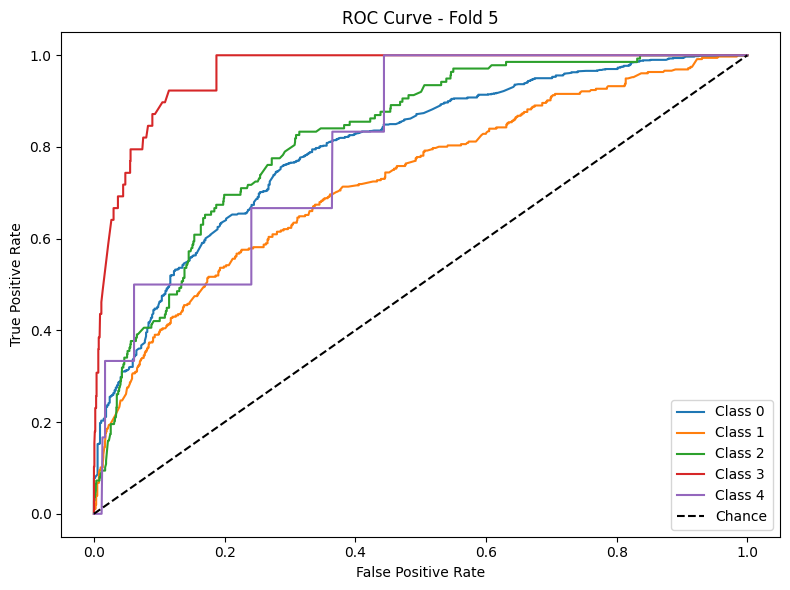


Average Accuracy: 0.6016
Average F1 Macro: 0.3984
Average AUC: 0.8281


In [8]:
# TRAINING WITH SMOTE
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)
    
    temp = "sample" if sample else "no_sample"
    
    model.save(f"best_model_{temp}_phase{i}.keras")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       568
           1       0.21      0.44      0.28        63
           2       0.28      0.35      0.31        43
           3       0.27      0.20      0.23        15
           4       0.00      0.00      0.00         9

    accuracy                           0.72       698
   macro avg       0.33      0.36      0.34       698
weighted avg       0.79      0.72      0.74       698



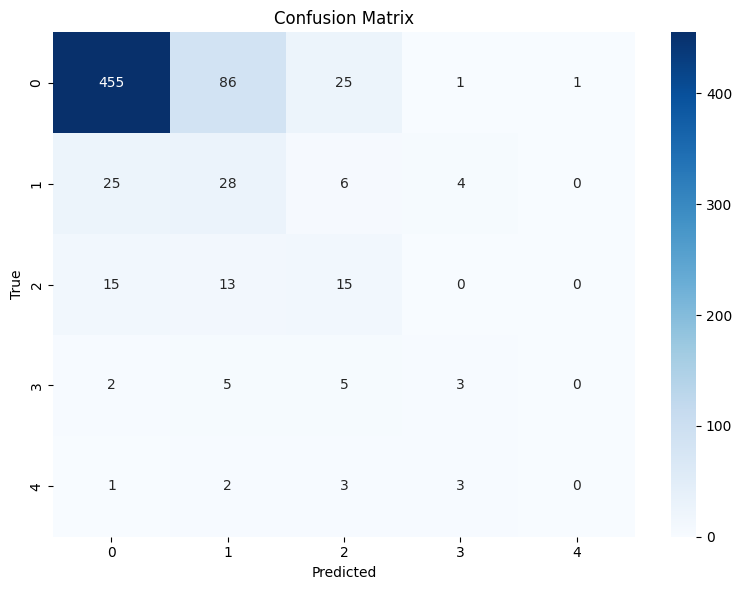


Test AUC (macro-average, OVR): 0.8136


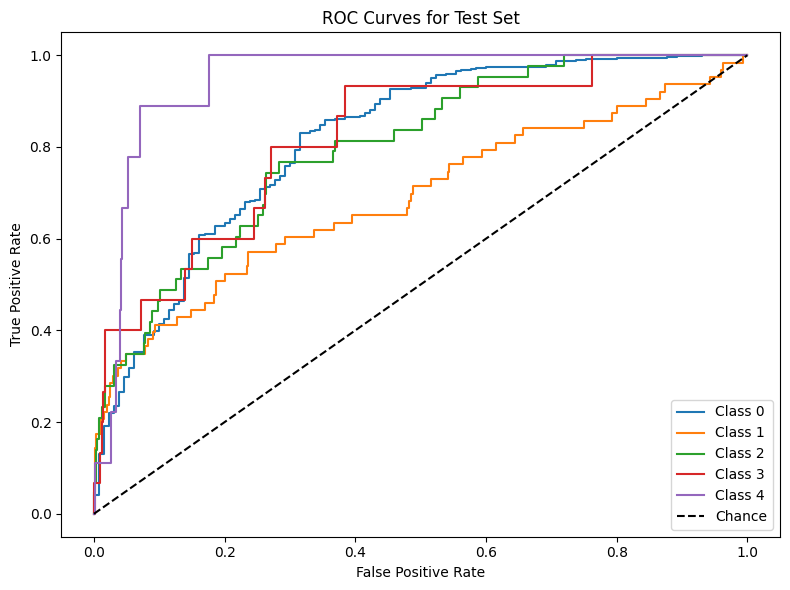

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       544
           1       0.16      0.25      0.20        59
           2       0.23      0.38      0.29        42
           3       0.10      0.07      0.08        14
           4       0.00      0.00      0.00         9

    accuracy                           0.72       668
   macro avg       0.28      0.31      0.29       668
weighted avg       0.78      0.72      0.75       668



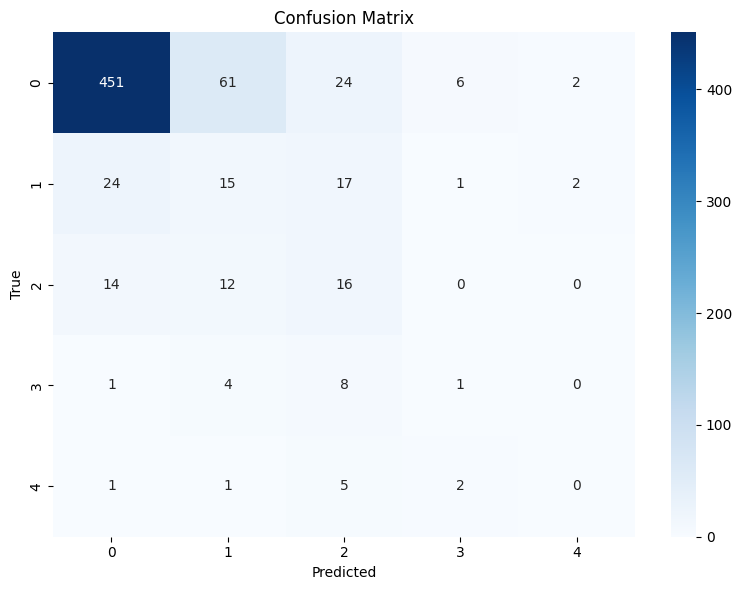


Test AUC (macro-average, OVR): 0.7990


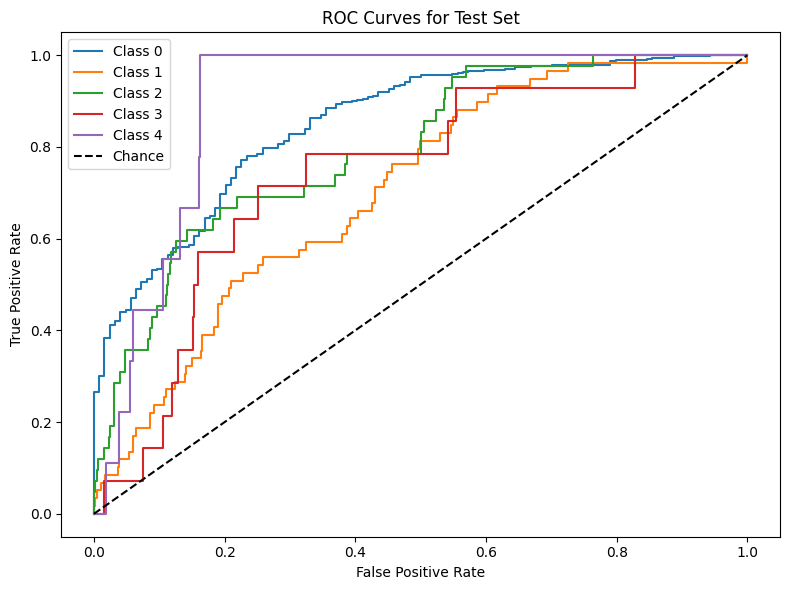

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       455
           1       0.21      0.44      0.28        52
           2       0.24      0.17      0.20        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.71       554
   macro avg       0.27      0.28      0.26       554
weighted avg       0.76      0.71      0.73       554



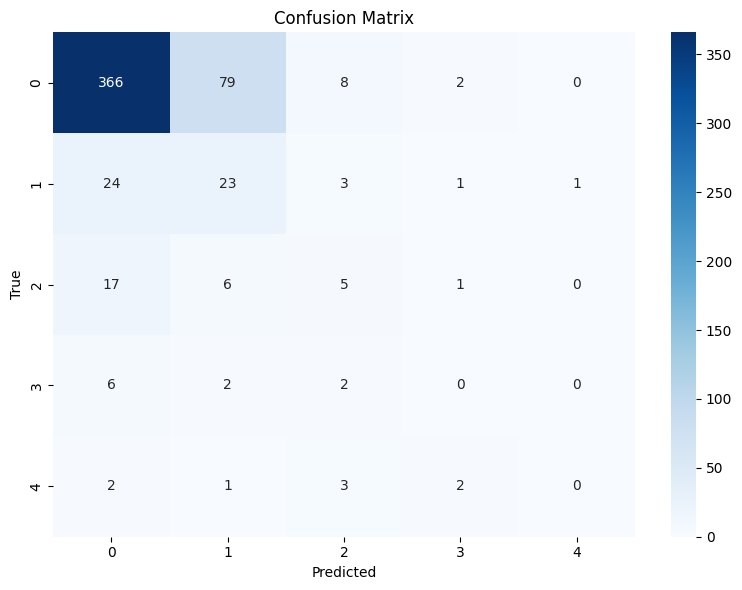


Test AUC (macro-average, OVR): 0.8000


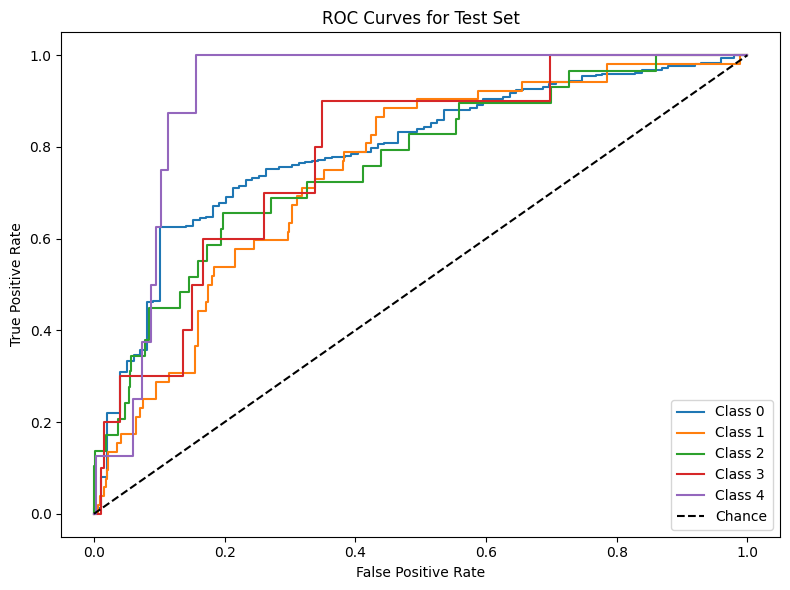

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       395
           1       0.16      0.55      0.24        40
           2       0.19      0.46      0.27        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.61       477
   macro avg       0.26      0.33      0.26       477
weighted avg       0.80      0.61      0.67       477



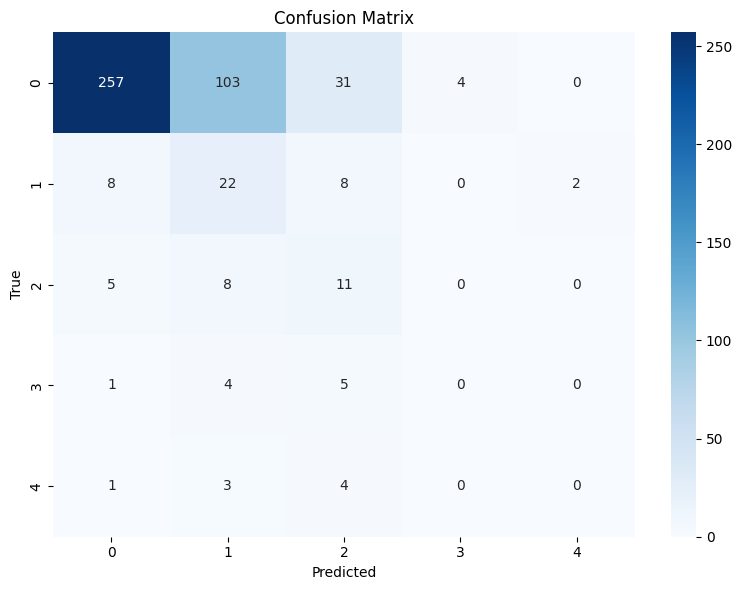


Test AUC (macro-average, OVR): 0.7634


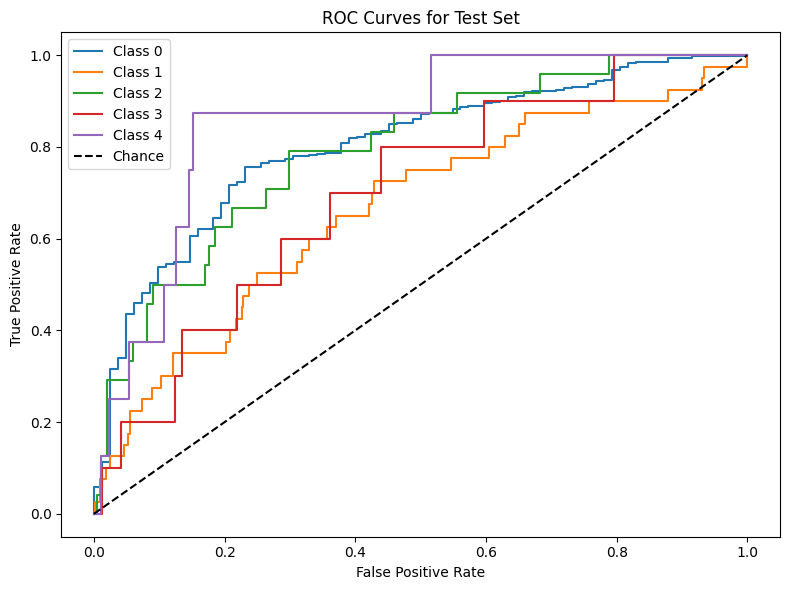

In [9]:
# PREDICTION LOOP WITH SMOTE
temp = "sample"  # must match training

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.keras'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)